# **Predicting Banking Member Conversion from Auto Loans**

# Required Files
This notebook stands alone in its running ability and does not require any files to be uploaded or read in. Future work is required to have their own unique login credentials to the data warehouse, Snowflake, and granted access to member data by the Credit Union if they choose to rerun and replicate this project.

## Abstract

This research explores customer conversions within banking, focusing on transitions from indirect to converted indirect members in a credit union. This research is done to aid banking institutions in enhancing customer relationships and optimizing conversion strategies. Using regression modeling and machine learning, I identify key factors driving conversions. Base logistic regression emerges as optimal for its simplicity and interpretability, informing demographic model utilization. Targeted advertising and promotions are recommended to facilitate conversions. Leveraging demographic data, cost-effective approaches are proposed, emphasizing importance on the variables, AGE_CLASS and STATE_STATUS.

## Introduction

Within the banking industry, there's often a misconception that it merely offers basic services such as checking accounts. However, beneath this surface lies an array of financial products and services catering to a diverse spectrum of individuals— from those seeking simple account solutions to others using intricate financial services, like mortgages and investments. Integral to this dynamic relationship between banks/financial institutions and their customers is the process of conversion, where customers transition from one service to another, guided by their changing needs and aspirations, as well as the financial institution. From this, and the substantial interest that exists, there stems a large focus and study within the banking industry into the causes and influences that result in customer conversions from one product to another. In discovering these impacts, banking firms are able to more accurately advertise their services to applicable potential and current customers— creating better relationships with their members— while customers are able to come into contact with services that can benefit them in their lives— present or future— as well.

This project delves into the realm of customer conversion within the banking sphere, focusing specifically on the journey of members within a Credit Union. The basis of this research aims to assist the Credit Union in better understanding and serving its members, by unraveling the trends and patterns underlying the conversion of indirect members to converted indirect members. An indirect member is defined as a customer who started their relation with the Credit Union through a car loan obtained from a car dealership, with no previous relation to the Credit Union and no direct contact between the customer and the Credit Union. A converted indirect member is defined as a member who started as an indirect member, and then opened up any other service with the Credit Union, establishing that financial connection between the two.

The pursuit of understanding customer conversion is not novel within the banking industry. Over the years, financial institutions have recognized the significance of discovering and understanding the factors influencing customer conversion patterns. This recognition has fueled a strong interest and extensive study into the nuances of customer conversion dynamics. From early explorations into consumer perspectives to advancements in data analytics and machine learning, deciphering the intricacies of customer conversion has been a persistent endeavor.

Against this backdrop, this project seeks to contribute to the knowledge surrounding customer conversion in the banking sector, with specific application to the Credit Union. By employing a multifaceted approach with data visualization, regression modeling, and machine learning techniques, the project intends to uncover potential connections between a member's characteristics or financial behaviors and their susceptibility for conversion. The findings from this research are given to empower the Credit Union to tailor and advertise its services more effectively, thereby fostering stronger and solidified relationships with its members and ensuring their financial well-being through conversion from an indirect member to a converted indirect member.

## Methods

### Package Importing and Dependencies

In [ ]:
pip install snowflake-connector-python==2.7.9

In [ ]:
pip install --upgrade snowflake-sqlalchemy

In [ ]:
pip install "snowflake-connector-python[pandas]"

In [ ]:
pip install typing-extensions --upgrade

In [ ]:
# Standard libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Statistical analysis
import statistics
import scipy.stats as stats
import statsmodels.formula.api as smf

# Machine Learning
from sklearn.datasets import make_regression
from sklearn import datasets, linear_model, metrics
from sklearn.utils import resample as math_resample  # Renamed to avoid conflict with 'import math'
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.svm import SVC

# Joblib for model persistence
import joblib

# Yellowbrick for visualization
from yellowbrick.regressor import ResidualsPlot

# External database connection
import snowflake.connector

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

### Snowflake and SQL
The Credit Union uses a cloud-based data warehouse called Snowflake. Through Snowflake, the data regarding members and conversion is kept securely in our sponsor's possession and is stored in an optimized schema.

1. To begin accessing the data, a snowflake connector must be instantiated. I will use the credentials and schema provided. For future work and replication, unique credentials must be used to access the Snowflake warehouse.
2. Now the database can be queried using SQL. Starting off by making a simple table, ALL_MEMBER_STATUS: this table has 2 columns, ID and STATUS. This table will be used only to understand the count and proportions of the member types.
3. Here I make a table that has only the indirect origin members. This is the subset of all members. The first column is ID, and the second is simply a binary variable of conversion status.
4. Using the newly created table from step 3, I build a larger table containing all the predictor variables— member data— of interest along with the ID's and conversion status. This is done by joining existing tables in the database on the new table. The result is a wide table containing indirect origin members, their conversion status (response), and account information (explanatory).


Since the tables in steps 2 - 4 have already been created, it would be redundant to run and keep recreating them. In order to not waste resources, the code has been commented out.


5. Finally, some select clauses are run to get the new tables. They are then stored in a pandas dataframe. Now the data is in the local notebook, ready for use.

#### Login

In [ ]:
# 1.
# Login to Snowflake

sf_connector = snowflake.connector.connect(
    user='',
    password='',
    account='',
    warehouse='',
    database='',
    schema='',
    role = ''
            )
sf_cursor = sf_connector.cursor()

#### SQL Code

In [ ]:
# 2.
"""
sql_MakeMemberTable = '''
CREATE OR REPLACE table ALL_MEMBER_STATUS AS

SELECT
    MEMBER_IDENTIFIER,
    CASE
        WHEN CONVERTED_INDIRECT = 1 AND ORIGINATED_INDIRECT = 1 THEN 'CONVERT'
        WHEN ORIGINATED_INDIRECT = 1 AND CURRENTLY_INDIRECT = 1 THEN 'INDIRECT'
        ELSE 'FULL'
    END AS STATUS
FROM
    CU_DENVER.SPRING_2024.INDIRECT_STATUS;
'''
sf_cursor.execute(sql_MakeMemberTable)
"""


# 3.
"""
sql_IndirectOriginTable = '''
CREATE OR REPLACE table INDIRECT_ORIGIN_MEMBERS AS

SELECT
    MEMBER_IDENTIFIER,
    CASE
        WHEN ORIGINATED_INDIRECT = 1 AND CONVERTED_INDIRECT = 1 THEN 1
        WHEN ORIGINATED_INDIRECT = 1 AND CURRENTLY_INDIRECT = 1 THEN 0
        ELSE NULL
    END AS CONVERTED
FROM CU_DENVER.SPRING_2024.INDIRECT_STATUS
WHERE
    (ORIGINATED_INDIRECT = 1);
'''
sf_cursor.execute(sql_IndirectOriginTable)
"""


# 4.
"""
sql_MakeIndirectTable = '''
CREATE OR REPLACE TABLE INDIRECT_FULL AS
SELECT
    IOM.*,
    MDL.STANDARDIZED_CITY_NAME,
	MDL.STANDARDIZED_STATE,
    AOH.OPEN_DATE,
    AOH.CLOSE_DATE,
    AOH.ACCOUNT_TYPE,
    ATPHI.IN_BRANCH_AVG,
    ATPHI.TRANSFER_AVG,
    ATPHI.COUNT_TX,
    ATPHI.MAX_TX,
    ATPHI.MIN_TX,
    ATPHI.AVG_TX_AMT,
    ATPHI.BALANCE_AVG,
    ATPHI.MAX_BALANCE,
    ATPHI.MIN_BALANCE,
    ATPHI.AVG_BALANCE_CHANGE,
    ATPHI.CARD_AVG,
    MDC.AGE_CLASS,
	MDC.EDUCATION_CLASS,
	MDC.EMPLOYMENT_CLASS,
	MDC.MEDIAN_HH_INCOME,
	MDC.MEDIAN_NET_WORTH,
	DTA.LOGIN_COUNT,
	DTA.TRANSFER_COUNT,
	DTA.ALL_OTHER_TYPE_COUNT,
	DTA.FAILURE_COUNT,
	DTA.SUCCESS_COUNT
FROM
    CU_DENVER.SPRING_2024.INDIRECT_ORIGIN_MEMBERS AS IOM
LEFT JOIN
    CU_DENVER.SPRING_2024.MEMBER_DEMOGRAPHIC_LOCATION AS MDL
ON
    IOM.MEMBER_IDENTIFIER = MDL.MEMBER_IDENTIFIER
LEFT JOIN
    CU_DENVER.SPRING_2024.ACCOUNT_OPEN_HISTORY AS AOH
ON
    IOM.MEMBER_IDENTIFIER = AOH.MEMBER_IDENTIFIER
LEFT JOIN
    CU_DENVER.SPRING_2024.ALL_TIME_PAYMENT_HISTORY_INDIRECT AS ATPHI
ON
    IOM.MEMBER_IDENTIFIER = ATPHI.MEMBER_IDENTIFIER
LEFT JOIN
    CU_DENVER.SPRING_2024.MEMBER_DEMOGRAPHIC_CHARACTERISTICS AS MDC
ON
    IOM.MEMBER_IDENTIFIER = MDC.MEMBER_IDENTIFIER
LEFT JOIN
    CU_DENVER.SPRING_2024.DIGITAL_TRANSACTION_AGGREGATE AS DTA
ON
    IOM.MEMBER_IDENTIFIER = DTA.MEMBER_IDENTIFIER;
'''
sf_cursor.execute(sql_MakeIndirectTable)
"""


# 5.
sql_getAllMember = '''
select *
from CU_DENVER.SPRING_2024.ALL_MEMBER_STATUS
'''
sf_cursor.execute(sql_getAllMember)
all_member_status = sf_cursor.fetch_pandas_all()

sql_getIndirect = '''
select *
from CU_DENVER.SPRING_2024.INDIRECT_FULL
'''
sf_cursor.execute(sql_getIndirect)
indirect_full = sf_cursor.fetch_pandas_all()

### Data

As this exploratory analysis delves into the associations linked to converting from an indirect member to a converted indirect member, this restricts the data that can be used. For members who started as a Full Member (blue) — those who started their business with the Credit Union through direct interaction— there does not exist any data to look into their conversion, as it did not happen. This limit denotes that our data set is a subset of all of the data held by the Credit Union on all of their members— approximately 19.6% of all of the data. This research and data set will only be focusing on those who originated as an Indirect Member — exemplified by the yellow highlighted portion of the diagram below. Of those Indirect Members, the green signifies the Converted Indirect.
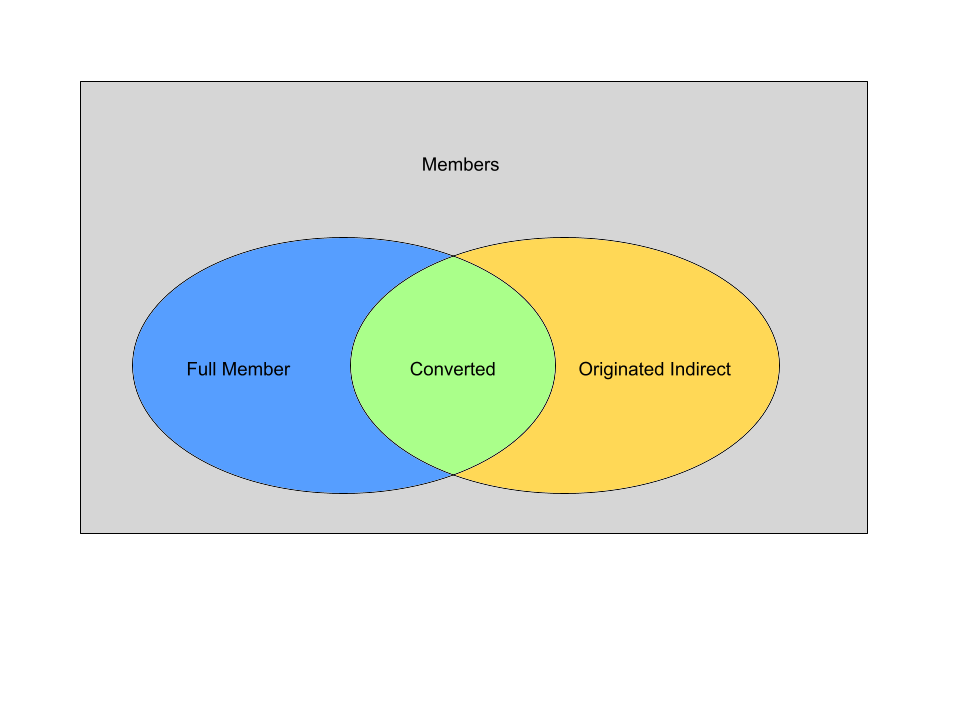

The indirect full data table that is being used within this project consists of 28 columns and 34,497 rows. As shown in the commented code above, it is the joining of 6 different tables. In total, it occupies around 3.9 MB of storage on the Snowflake server. The All Member Status table, which is only used briefly for some visualizations, has 173,988 rows with only 2 columns. It is 10.2 MBs of storage. Below I explore the indirect full table: we can see variable names, data types, descriptions, source, and level of measurement.

---
Variable      |  Data Type    | Description | Source | Quantitative/Categorical
------------- | ------------- | ----------- | ------ | --------------
MEMBER_IDENTIFIER  | Object  | Unique ID for each member | Sponsor | Categorical
CONVERTED  | int8 | Has loan customer converted to full credit union member? (Binary 0 or 1) | Student | Categorical
STANDARDIZED_CITY_NAME  | Object | City where member resides | Sponsor |Categorical
STANDARDIZED_STATE  | Object  | State where member resides | Sponsor | Categorical
OPEN_DATE  | Object  | Date of first account opening | Sponsor | Categorical
CLOSE_DATE  | Object  | Date of account closure | Sponsor | Categorical
ACCOUNT_TYPE  | Object | Type of credit union account | Sponsor | Categorial
IN_BRANCH_AVG  | Float64 | Proportion of a member's transactions which took place in branch (range from 0-1)| Sponsor | Quantitative
TRANSFER_AVG | Float64 | Proportion of a member's transactions which were transfers (range from 0-1)| Sponsor | Quantitative
COUNT_TX  | Float64 | Total number of member transactions | Sponsor | Quantitative
MAX_TX | Float64 | Member's maximum transaction amount (USD) | Sponsor | Quantitative
MIN_TX  | Float64 | Member's minimum transaction amount (USD) | Sponsor | Quantitative
AVG_TX_AMT | Float64 | Member's average transaction amount (USD)| Sponsor | Quantitative
BALANCE_AVG | Float64 | Member's average account balance (USD) | Sponsor | Quantitative
MAX_BALANCE | Float64 | Member's maximum account balance (USD) | Sponsor | Quantitative
MIN_BALANCE | Float64 | Member's minimum account balance (USD) | Sponsor | Quantitative
AVG_BALANCE_CHANGE | Float64 | Member's average in change of balance (USD) | Sponsor | Quantitative
CARD_AVG | Float64  | Average card transaction amount (USD) | Sponsor | Quantitative
AGE_CLASS | Object  | Member's age (grouped) | Sponsor | Categorical
EDUCATION_CLASS | Object  | Member's estimates education level | Sponsor | Categorical
EMPLOYMENT_CLASS | Object  | Member's estimated employment level | Sponsor | Categorical
MEDIAN_HH_INCOME | Float64  | Member's estimate household income (USD per year) | Sponsor | Quantitative
MEDIAN_NET_WORTH | Float64  | Member's estimated net worth (USD per yer)| Sponsor | Quantitative
LOGIN_COUNT | Float64  | Count of logins to member's online banking account | Sponsor | Quantitative
TRANSFER_COUNT | Float64  | Count for number of transactions made by member | Sponsor | Quantitative
ALL_OTHER_TYPE_COUNT | Float64  | Total number of interactions that are not login, transfer, failure, or success | Sponsor | Quantitative
FAILURE_COUNT | Float64  | Number of failed logins to a member's online banking account | Sponsor | Quantitative
SUCCESS_COUNT | Float64  | Number of successful logins to a member's online banking account | Sponsor | Quantitative
STATE_STATUS | Object  | Designates whether a member resides within Colorado or not | Student | Categorical

### Data Cleaning & Filtering

The first step taken in working with the data set was to clean the data. There were not many discrepancies within the data set, though the majority of the cleaning process revolved around handling missing values. These missing values were identified, and evaluated for their relevancy, discovering if they were to be removed or transformed into a real value (0). The missing values were then handled accordingly. Each of the variables corresponding to digital banking (LOGIN_COUNT, TRANSFER_COUNT, ALL_OTHER_TYPE_COUNT, FAILURE_COUNT, and SUCCESS_COUNT) had around 39% of the observation be null values, which were all changed to 0. The null values were able to be transformed into 0, as they represented that a member did not have any data corresponding to each variable since they had not used the digital banking service, displaying 0 login counts, 0 transfer counts, 0 counts of any other interaction, 0 failed logins, and 0 successful logins.

In [ ]:
indirect_full['STATE_STATUS'] = indirect_full['STANDARDIZED_STATE'].apply(lambda x: 'CO' if x == "CO" else 'Other')

In [ ]:
def count_null_values(data):
    for column in data.columns:
        null_count = data[column].isnull().sum()
        print(column, "has", null_count, "null values.")

count_null_values(indirect_full)

MEMBER_IDENTIFIER has 0 null values.
CONVERTED has 0 null values.
STANDARDIZED_CITY_NAME has 472 null values.
STANDARDIZED_STATE has 472 null values.
OPEN_DATE has 0 null values.
CLOSE_DATE has 34242 null values.
ACCOUNT_TYPE has 0 null values.
IN_BRANCH_AVG has 68 null values.
TRANSFER_AVG has 68 null values.
COUNT_TX has 68 null values.
MAX_TX has 68 null values.
MIN_TX has 68 null values.
AVG_TX_AMT has 68 null values.
BALANCE_AVG has 68 null values.
MAX_BALANCE has 68 null values.
MIN_BALANCE has 68 null values.
AVG_BALANCE_CHANGE has 68 null values.
CARD_AVG has 34497 null values.
AGE_CLASS has 139 null values.
EDUCATION_CLASS has 185 null values.
EMPLOYMENT_CLASS has 185 null values.
MEDIAN_HH_INCOME has 185 null values.
MEDIAN_NET_WORTH has 185 null values.
LOGIN_COUNT has 13507 null values.
TRANSFER_COUNT has 13507 null values.
ALL_OTHER_TYPE_COUNT has 13507 null values.
FAILURE_COUNT has 13507 null values.
SUCCESS_COUNT has 13507 null values.
STATE_STATUS has 0 null values.


In [ ]:
# List of columns to update
columns_to_fill = ['LOGIN_COUNT', 'TRANSFER_COUNT', 'ALL_OTHER_TYPE_COUNT', 'FAILURE_COUNT', 'SUCCESS_COUNT']

# Replace null values with 0 in the specified columns
indirect_full[columns_to_fill] = indirect_full[columns_to_fill].fillna(0)

count_null_values(indirect_full)

MEMBER_IDENTIFIER has 0 null values.
CONVERTED has 0 null values.
STANDARDIZED_CITY_NAME has 472 null values.
STANDARDIZED_STATE has 472 null values.
OPEN_DATE has 0 null values.
CLOSE_DATE has 34242 null values.
ACCOUNT_TYPE has 0 null values.
IN_BRANCH_AVG has 68 null values.
TRANSFER_AVG has 68 null values.
COUNT_TX has 68 null values.
MAX_TX has 68 null values.
MIN_TX has 68 null values.
AVG_TX_AMT has 68 null values.
BALANCE_AVG has 68 null values.
MAX_BALANCE has 68 null values.
MIN_BALANCE has 68 null values.
AVG_BALANCE_CHANGE has 68 null values.
CARD_AVG has 34497 null values.
AGE_CLASS has 139 null values.
EDUCATION_CLASS has 185 null values.
EMPLOYMENT_CLASS has 185 null values.
MEDIAN_HH_INCOME has 185 null values.
MEDIAN_NET_WORTH has 185 null values.
LOGIN_COUNT has 0 null values.
TRANSFER_COUNT has 0 null values.
ALL_OTHER_TYPE_COUNT has 0 null values.
FAILURE_COUNT has 0 null values.
SUCCESS_COUNT has 0 null values.
STATE_STATUS has 0 null values.


Due to the high number of variables within the data set, it was pertinent to filter the data set using subsets of the variables, as well as in regards to the response variable and which variables will be used in model creation.

7 subsets were created using the following criteria:
- Every variable (including the [response variable](https://online.stat.psu.edu/stat200/lesson/1/1.1/1.1.2) ('CONVERTED')
- Only numeric [explanatory variables](https://online.stat.psu.edu/stat200/lesson/1/1.1/1.1.2)
- A smaller subset of 9 numeric explanatory variables for plotting
- Only member demographic numeric explanatory variables
- Only categorical explanatory variables
- A smaller subset of 4 categorical explanatory variables for plotting
- Only member demographic categorical explanatory variables

These subsets were created for ease in data visualizations and model creations, as well as to reduce code repetition. With the large number of variables, only a smaller subset of the numeric and categorical variables were plotted in data visualizations.

In [ ]:
# Set of all variables that are used
indirect_small = indirect_full[['CONVERTED', 'IN_BRANCH_AVG', 'TRANSFER_AVG', 'COUNT_TX',
                               'MAX_TX', 'MIN_TX', 'AVG_TX_AMT', 'BALANCE_AVG',
                               'MAX_BALANCE', 'MIN_BALANCE', 'AVG_BALANCE_CHANGE',
                               'MEDIAN_HH_INCOME', 'MEDIAN_NET_WORTH', 'LOGIN_COUNT',
                               'TRANSFER_COUNT', 'ALL_OTHER_TYPE_COUNT', 'FAILURE_COUNT',
                               'SUCCESS_COUNT', 'ACCOUNT_TYPE', 'AGE_CLASS', 'EDUCATION_CLASS',
                               'EMPLOYMENT_CLASS', 'STATE_STATUS']]

# Set of all numeric variables used for modeling
numeric = ['IN_BRANCH_AVG', 'TRANSFER_AVG', 'COUNT_TX', 'MAX_TX', 'MIN_TX',
           'AVG_TX_AMT', 'BALANCE_AVG', 'MAX_BALANCE', 'MIN_BALANCE',
           'AVG_BALANCE_CHANGE', 'MEDIAN_HH_INCOME', 'MEDIAN_NET_WORTH',
           'LOGIN_COUNT', 'TRANSFER_COUNT', 'ALL_OTHER_TYPE_COUNT',
           'FAILURE_COUNT', 'SUCCESS_COUNT']

# Subset of numeric variables used for plotting
numeric_small = ['IN_BRANCH_AVG', 'TRANSFER_AVG', 'COUNT_TX', 'AVG_TX_AMT', 'BALANCE_AVG',
                 'AVG_BALANCE_CHANGE', 'MEDIAN_HH_INCOME', 'MEDIAN_NET_WORTH', 'LOGIN_COUNT']

# Subset of numeric variables used for demographic based modeling
numeric_demo = ['MEDIAN_HH_INCOME', 'MEDIAN_NET_WORTH']

# Set of all categorical variables used for modeling
categorical = ['ACCOUNT_TYPE', 'AGE_CLASS', 'EDUCATION_CLASS', 'EMPLOYMENT_CLASS',
               'STATE_STATUS']

# Subset of categorical variables used for plotting
categorical_small = ['ACCOUNT_TYPE', 'AGE_CLASS', 'EDUCATION_CLASS', 'EMPLOYMENT_CLASS']

# Subset of categorical variables used for demographic based modeling
categorical_demo = ['AGE_CLASS', 'EDUCATION_CLASS', 'EMPLOYMENT_CLASS', 'STATE_STATUS']

### Data Exploration

A variety of visualizations are used to pictorially represent the data, gain a deeper understanding of its structure, and look for patterns. I implemented:

- Pie charts
- Histograms
- [Correlation](https://en.wikipedia.org/wiki/Correlation) heatmap
- Scatterplots

These visualizations allowed for a look into the distributions of the variables and gain a better understanding of the data.

### Models

I chose to create and compare three different models for the data analysis:
- Base [logistic regression](https://www.ibm.com/topics/logistic-regression) model
- Logistic regression model with elastic net [regularization](https://www.ibm.com/topics/regularization#:~:text=Regularization%20is%20a%20set%20of,overfitting%20in%20machine%20learning%20models.)
- [Support vector machine model (SVM)](https://www.ibm.com/topics/support-vector-machine)

#### Logistic Regression

Within any interdisciplenary project including mathematics, there often lies a disconnect between conclusions and their explanations. In ensuring a high level of interpretability of the model, logistic regression (or logit regression) was chosen as a "paper-and-pencil" model, one whose conclusions could be easily explained, as well as the method in which it was created through.

Classic logistic regression is a statistical machine learning method that is used for binary classification, in which the response variable has two possible values (denoted 0 and 1). Logistic regression aims to estimate the probability that an observation belongs to a certain category, and models this probability using the logistic function (Sperandei 2014). This bounds each probability within 0 and 1. Each observation is then assigned to a response class of 0 or 1, based upon their probability compared to a set threshold, commonly 0.5-- i.e. if a probability for a given instance is 0.5 or above, then it is assigned to class 1, and vice versa.



In modeling the probability for an observation to be within a distinct class, the following equation is used:

$$ P(Y=K|\mathbf{x_i}) = p_i =  \frac{1}{1+ e^{-(β_0+β_1X_1+β_2X_2+...+β_nX_n)}}
$$

where,


*   $P(Y=K|\mathbf{x_i})$ is the probability that an observation $\mathbf{x_i}$, for i  =  1, 2, ... , N, belongs to class K within the response variable.
*   $\beta_0$ is the intercept
*   $\beta_1$, $\beta_2$, ..., $\beta_n$ are the regression coefficients, also known as variable weights, for their respective variables, $X_1$, $X_2$, ..., $X_n$. These values are estimating the true relationship between a variable, $X_n$ and $P(Y=K|\mathbf{x})$.

Applying the logistic function to bound the probabilities between 0 and 1, the following equation is obtained to model the log [odd ratio](https://en.wikipedia.org/wiki/Odds_ratio) (Szumilas 2010),

$$ \log(\frac{P(Y=K|\mathbf{x_i})}{1-P(Y=K|\mathbf{x_i})}) = \log(p_i) =  \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n
$$

The regression coefficients, $\beta_n$, are then analyzed as the variables' association with the response variable, taking into account both magnitude and sign of the regression coefficient.

In the creation of each model, the logistic regression model aims to minimize the [Log Loss function (also called the cross-entropy loss function)](https://en.wikipedia.org/wiki/Cross-entropy#Cross-entropy_loss_function_and_logistic_regression), a function that measures the difference in the predictions made from a model, and the actual observed value ($y_i$). The Log Loss function is defined as:


$$ J(\beta) = - \frac{1}{N} Σ_{i=1}^{N} [y_i \ log(p_i) \ + \ (1-y_i) \ log(1-p_i) ]
$$

#### Elastic Net

Elastic Net Logistic Regression is a type of regularized logistic regression model. In regularizing a model, the model is being constrained by certain limits to create a simpler model and reduce the risk of overfitting the model to the data (“What Is Regularization?” IBM). Elastic Net utilizes two types of regularization methods and is a mixture between the two; Ridge Regression and Lasso Regression, along with a parameter to control how strong the regularization is towards either method.

Elastic Net Logistic Regression aims to minimize a modified version of the Log Loss function, that includes the penalties from Ridge Regression and Lasso Regression:

$$ J(\beta) = - \frac{1}{N} Σ_{i=1}^{N} [y_i \ log(p_i) \ + \ (1-y_i) \ log(1-p_i) ] \  + \ r \alpha   Σ_{i=1}^{n}|\beta_i| \ + \ (\frac{1-r}{2})  \alpha  Σ_{i=1}^{n}\beta_i^2
$$

where,
* 𝑟 is the ratio at which the Ridge Regression and Lasso Regression are applied
* 𝛂 is the penalty/extent at which the regularization is applied
* N is the number of observations
* n is the number of variables being inputted into the model

#### Support Vector Machine (SVM)

For the last machine learning model, I chose to employ a type of SVM called a Support Vector Classifier. To explain this model, let's imagine a 2 dimensional data set. The goal of this model is to classify the data by means of drawing a line. All the points on one side of the line would classified as belonging to A (red), while points on the other side would belong to B (green). In 3 dimensional space, we could imagine this as instead of drawing a line to seperate the data, we are instead drawing a plane to do so.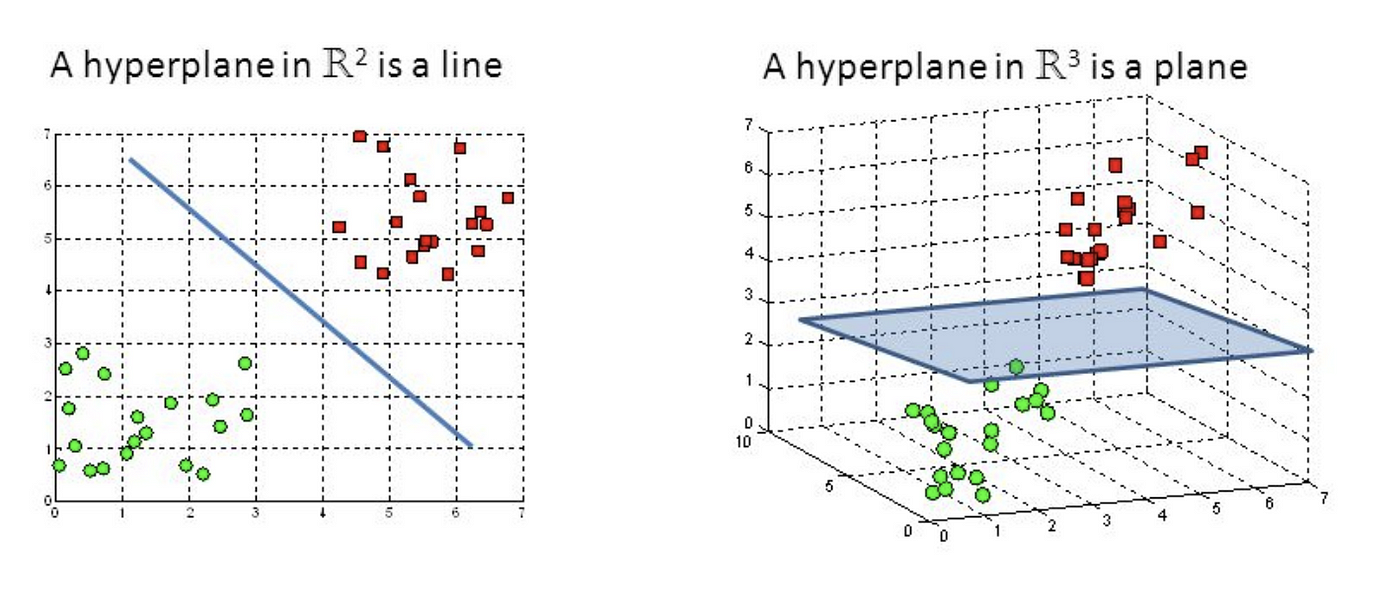

We can imagine that for our case, we are looking to divide the data into the classes converted and not converted with a divider called a hyperplane. However, instead of working in 2 or 3 dimensions as pictured above, we are working in an  $n$ - dimensional space, where $n$ is the number of variables in our data set ("What are support vector machines (SVMs)?
", IBM). This can become difficult to visualize, and here lies the main issue with SVM's in general. Unlike our pen and paper logistic regression model, the SVM has no easily interpretable coefficients. We cannot gauge a features importance as we can with the previous models. The SVM has a higher overall accuracy than the other models, however it also has less explainability. This kind of "black box" model ranks higher on innovation and accuracy, but lower on transparency and interpretability.

The Support Vector Machine model can be represented with:
1. **Hyperplane Equation**:
   The hyperplane in $n$-dimensional space can be defined by the equation:
   $$ w^T x + b = 0 $$
   where:
   - $w$ is the weight vector (normal to the hyperplane),
   - $x$ is an input vector,
   - $b$ is the bias term.

2. **Decision Function**:
   The decision function for a given input vector $x$ in $n$-dimensional space is:
   $$ f(x) = \text{sgn}(w^T x + b) $$
   Here, the dot product $w^T x$ calculates a scalar value, and the bias $b$ is added to this result.

3. **Sign Function Application**:
   The sign function $\text{sgn}$ is then applied to the scalar result of the dot product plus the bias:
   - If $w^T x + b > 0$, then $f(x) = +1$.
   - If $w^T x + b < 0$, then $f(x) = -1$.

  This scalar decision value determines the class of the input vector $x$ by checking which side of the hyperplane the point lies on. In our case, we can imagine that all points on one side of the hyperplane will be labeled converted while the others labeled not converted.

4. **Kernel Trick**

  In the implementation, the slightly different decision function is used
  $$ f(x) = \text{sgn}\left(\sum_{i=1}^n \alpha_i y_i K(x_i, x) + b\right) $$ where:
    - $α_i$ are the Lagrange multipliers.
    - $y_i$ are class labels.
    - $b$ is a bias term.
    - $K$ is a kernel function to handle the non-linear transformations necessary for complex datasets such as ours, but ultimately, the classification decision still hinges on the sign of the scalar sum.
    
5. **RBF Kernel**

  I chose to use a variation of the Radial Basis Function (RBF) kernel $K$, also known as the Gaussian kernel:

  $$ K(x_i, x_j) = \exp\left(-\gamma \cdot \|x_i - x_j\|^2\right) $$

  where:
  - $x_i, x_j$ are two feature vectors.
  - $\gamma$ is a parameter that sets the "spread" of the kernel. Higher values of $\gamma$ will lead to a narrower peak (closer fitting to the training data).
  The SVM with an RBF kernel aims to solve the following optimization problem:

  $$ \min_{\alpha} \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j K(x_i, x_j) - \sum_{i=1}^n \alpha_i $$

  subject to:

  $$ 0 \leq \alpha_i \leq C $$
  $$ \sum_{i=1}^n \alpha_i y_i = 0 $$

  where:
  - $C$ is the regularization parameter, which controls the trade-off between achieving a low training error and a low testing error (generalization).
  (R. Berwick, 2003)


#### Demographic Modeling

Since the Credit Union will not have banking data on new and/or potential auto loan customers, it is helpful to be able to make predictions about conversion based solely on demographic data, which can be gathered from loan applications or purchased from third parties.

In consideration of this I trained each model again, but using only the demographic data. Also, in order to save on costs related to purchasing demographic data from third parties, we compared the accuracies of each combination of demographic features in the base logistic regression model to find the most efficient set of features. Thus allowing for accurate predictions with low costs.



## Results and Discussion

### Data Exploration

In order to better understand the data and different distributions that lie within each variable, different data visualization techniques were implemented to look at the data at both a macro and micro level.

The following pie chart displays that the data used within this research— pertaining to only indirect members— is approximately 19.6% of all of the data available from the Credit Union.

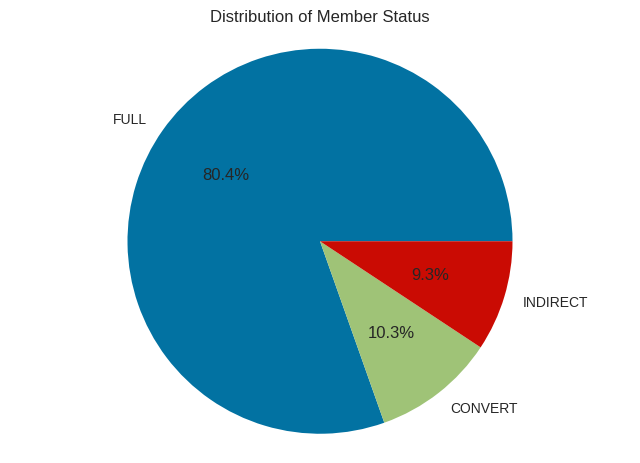

In [ ]:
status_counts = all_member_status['STATUS'].value_counts()

plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Member Status')
plt.axis('equal')
plt.show()

Of the Credit Union members that are being studied in this research, roughly 81% of them are residents of Colorado.

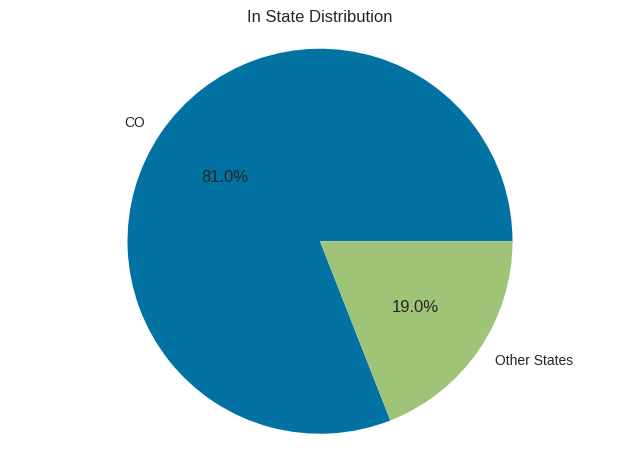

In [ ]:
is_co = indirect_full['STANDARDIZED_STATE'] == 'CO'
state_summary = is_co.value_counts().rename(index={True: 'CO', False: 'Other States'})

plt.pie(state_summary, labels=state_summary.index, autopct='%1.1f%%')
plt.title('In State Distribution')
plt.axis('equal')
plt.show()

The majority of users range from 25 to 54 years of age. Of the indirect members, the most frequent education level is High school or some form of a graduate degree. This observation is quite interesting as this Credit Union appears to be applicable to both younger generations, as well as older, acting as a starting and continuing financial entity.

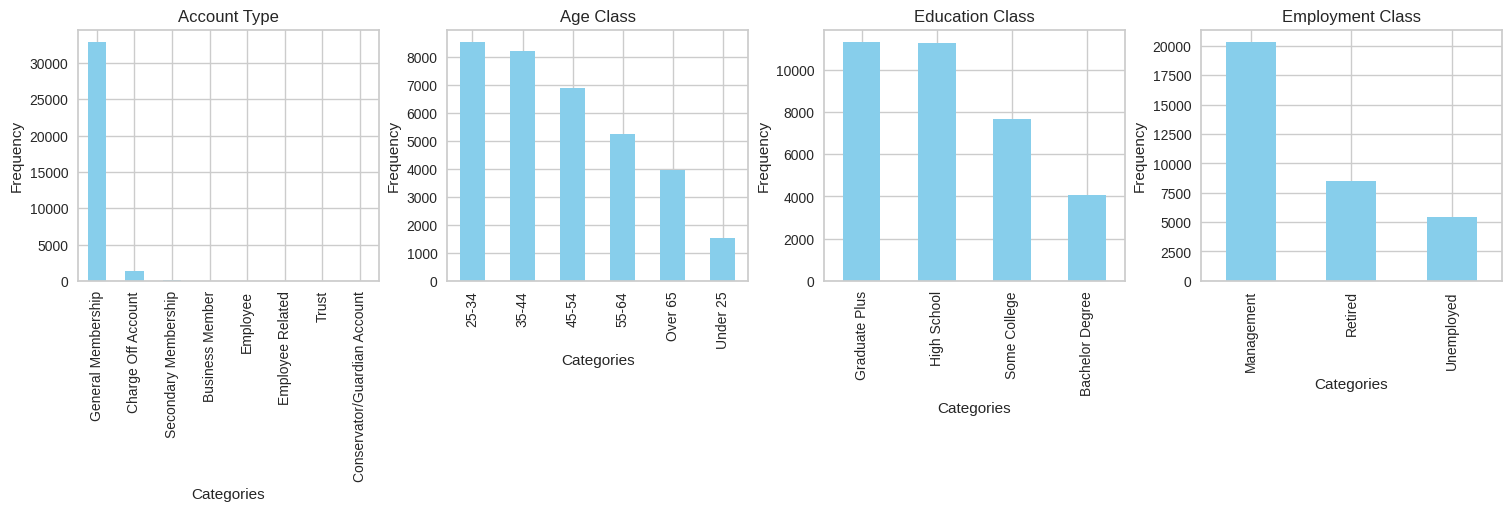

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5), constrained_layout=True)

for i, var in enumerate(categorical_small):
    indirect_full[var].value_counts().plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(var.replace('_', ' ').title())
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=90)

plt.show()

In order to analyze the relationships between input variables and identify potential instances of collinearity, the following correlation heat matrix was created and analyzed. Since the correlation between AVG_TX_AMT and AVG_BALANCE_CHANGE is 1.00 there is no need to have both, so it can be removed from indirect_small, numeric, and numeric_small. While there exists high collinearity between certain variables, for the purpose of retaining as much data as possible, all other variables were left in the data set.

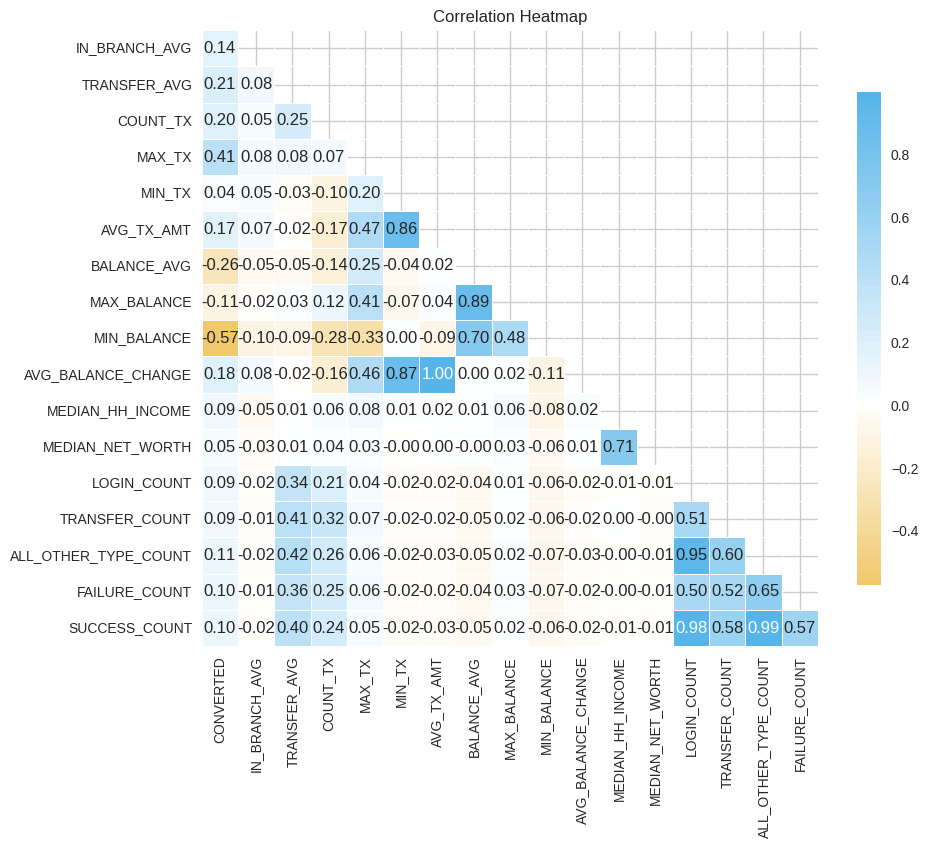

In [ ]:
correlation_matrix = indirect_small.corr().iloc[1:, :-1]
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), 1)

cmap = LinearSegmentedColormap.from_list(name='Custom', colors=["#E69F00", "white", "#56B4E9"], N=100)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Remove AVG_BALANCE_CHANGE from indirect_small
indirect_small = indirect_small.drop('AVG_BALANCE_CHANGE', axis=1)

# Remove AVG_BALANCE_CHANGE from numeric
numeric = [col for col in numeric if col != 'AVG_BALANCE_CHANGE']

# Remove AVG_BALANCE_CHANGE from numeric_small
numeric_small = [col for col in numeric_small if col != 'AVG_BALANCE_CHANGE']

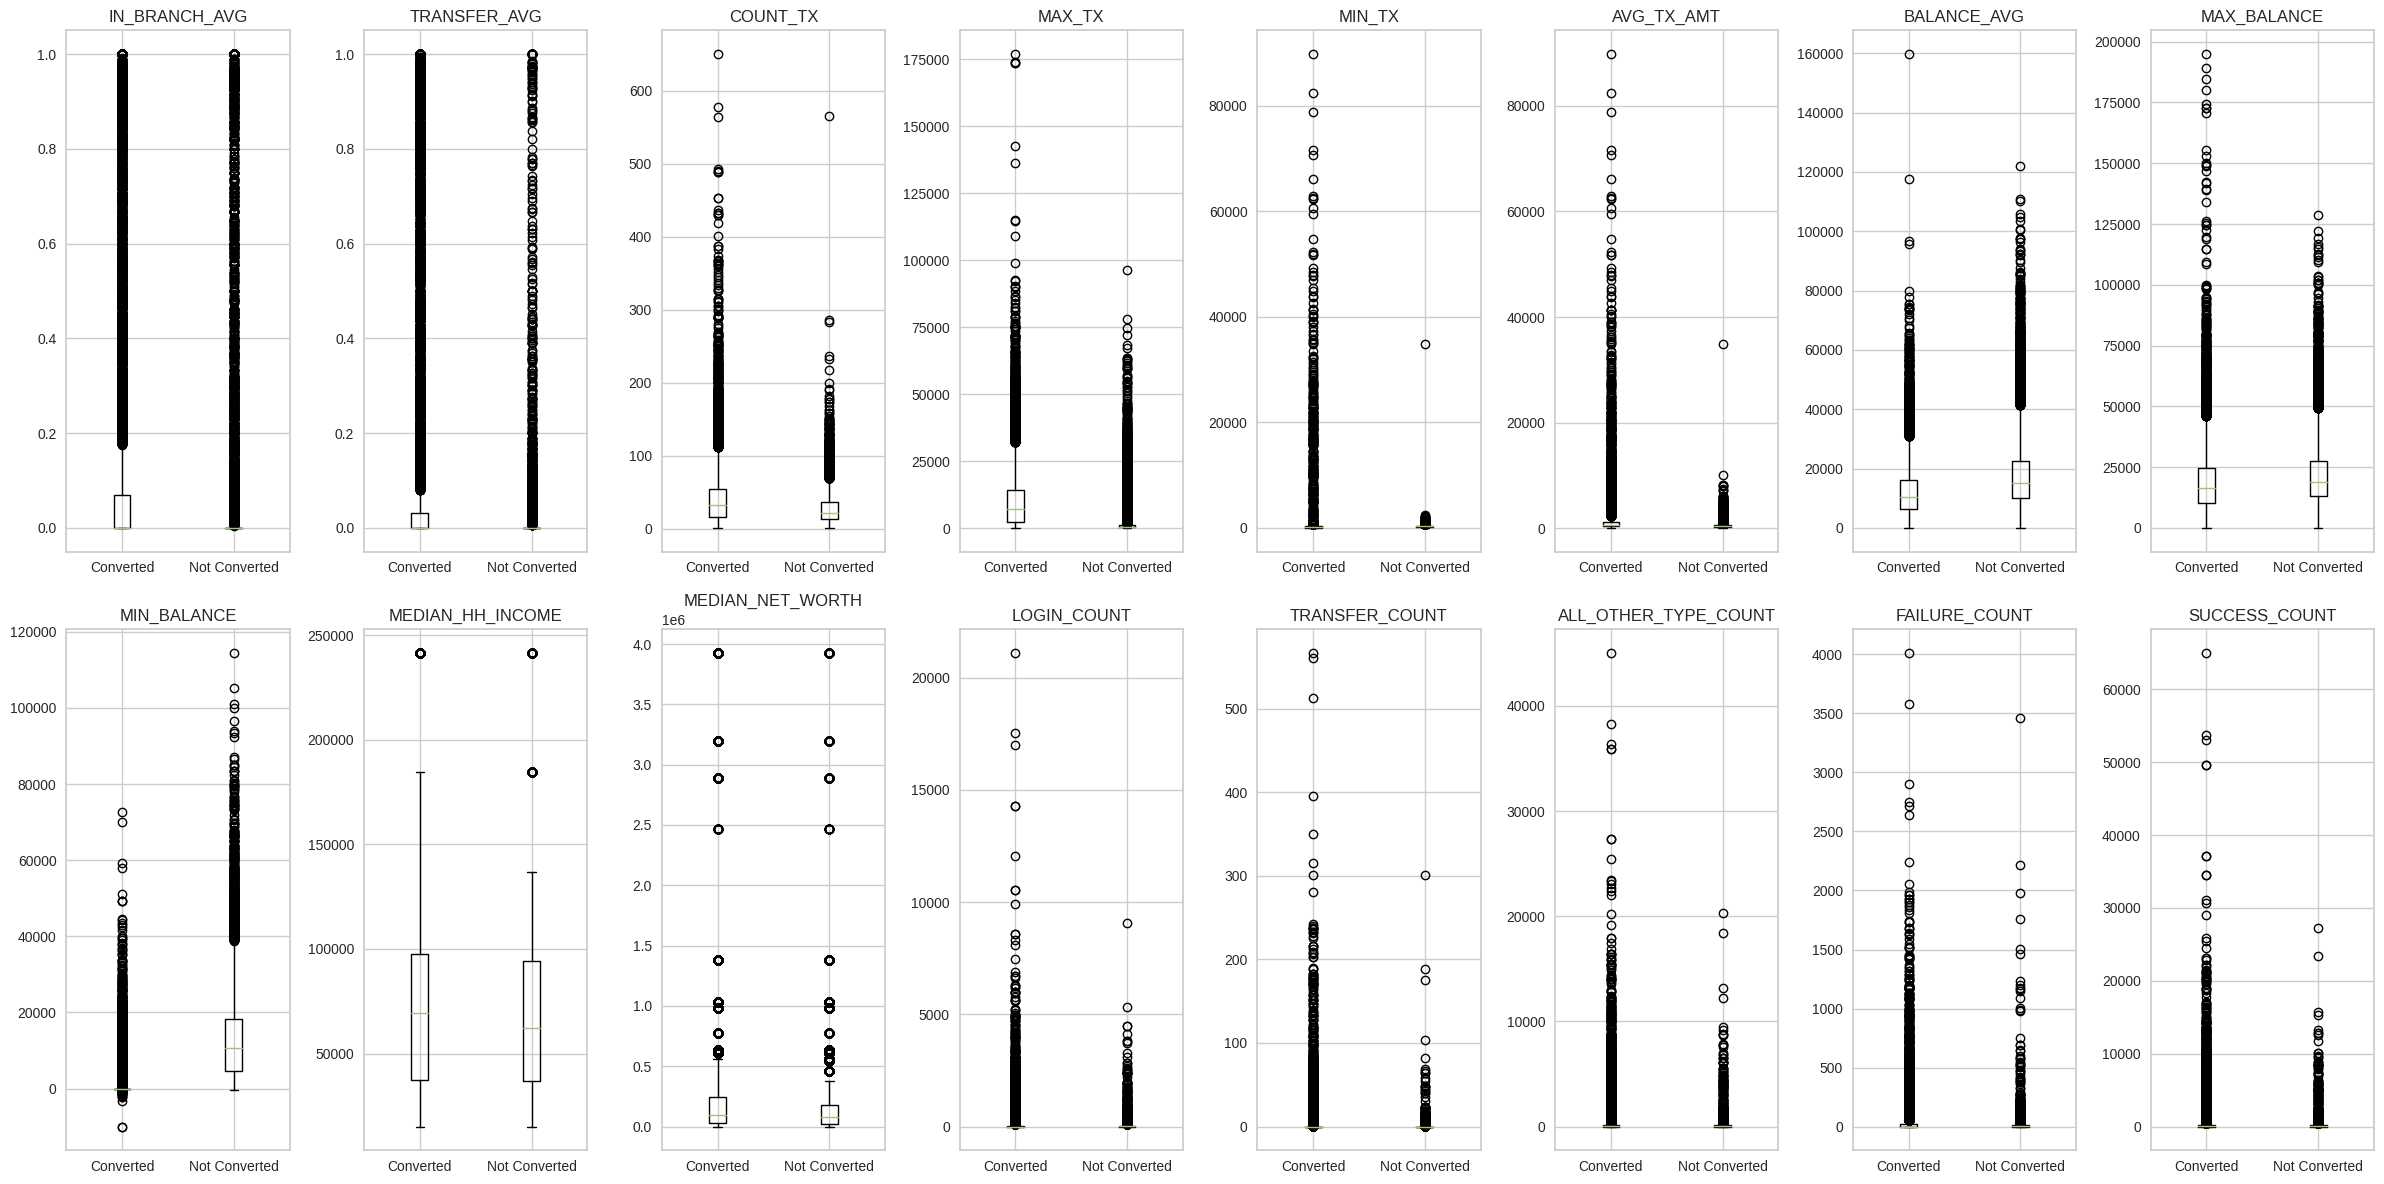

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(24, 12))

for i, variable in enumerate(numeric):
    row = i // 8
    col = i % 8

    converted = indirect_small[indirect_small['CONVERTED'] == 1][variable].dropna()
    not_converted = indirect_small[indirect_small['CONVERTED'] == 0][variable].dropna()

    ax = axes[row, col]
    ax.boxplot([converted, not_converted], labels=['Converted', 'Not Converted'])
    ax.set_title(variable)

plt.tight_layout()
plt.show()

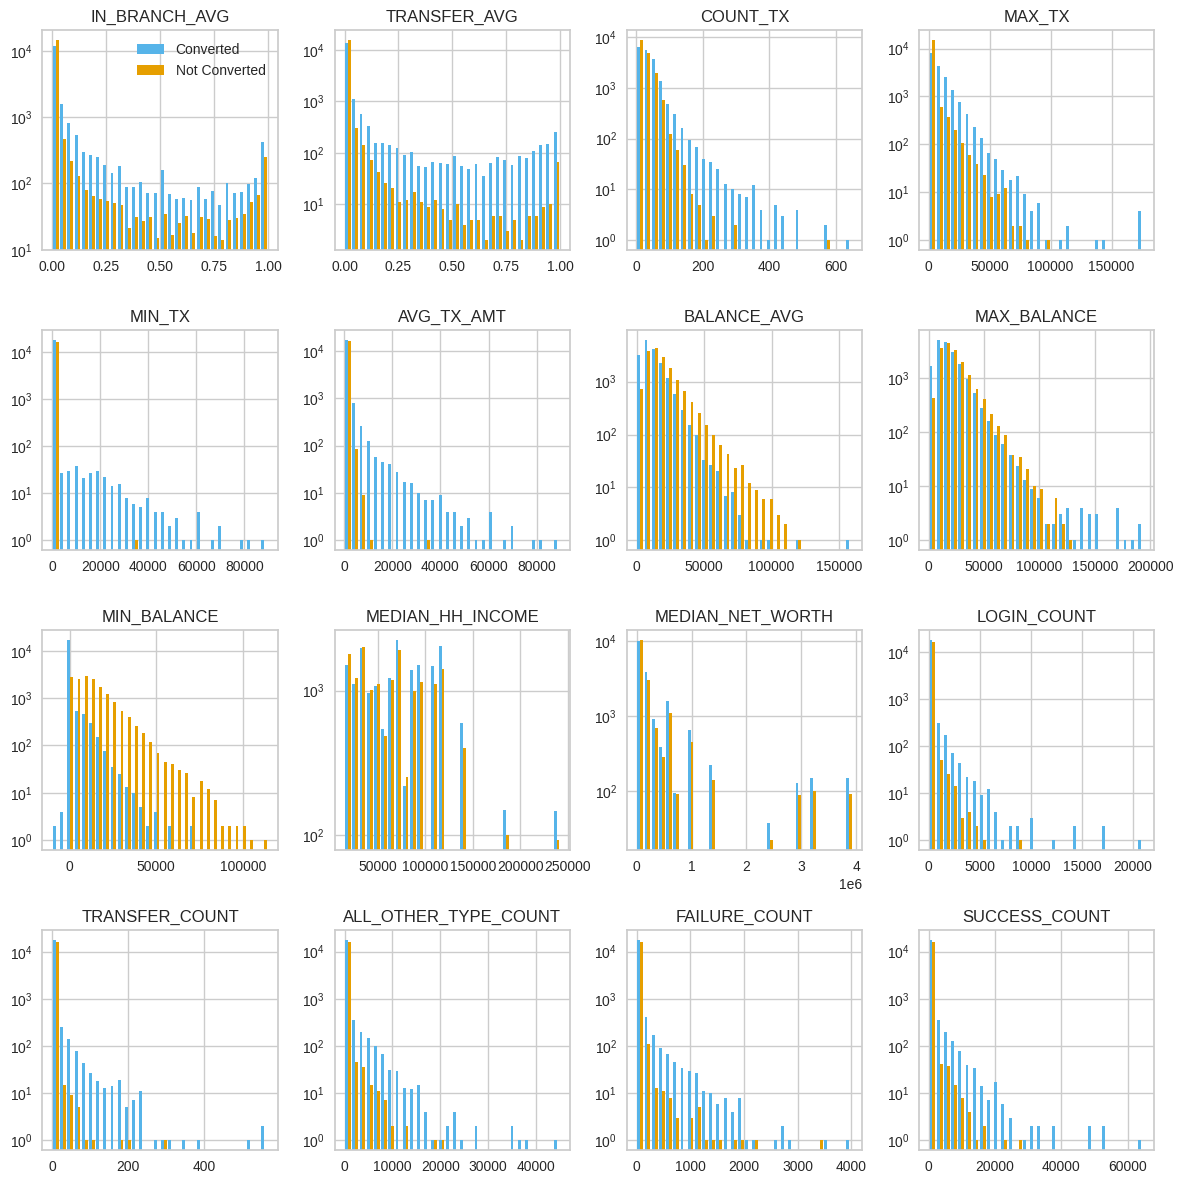

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

for i, variable in enumerate(numeric):
    row = i // 4
    col = i % 4

    converted = indirect_small[indirect_small['CONVERTED'] == 1][variable].dropna()
    not_converted = indirect_small[indirect_small['CONVERTED'] == 0][variable].dropna()

    ax = axes[row, col]
    ax.hist([converted, not_converted], bins=30, label=['Converted', 'Not Converted'],
            color=['#56B4E9', '#E69F00'], log=True)
    ax.set_title(variable)
    if row == 0 and col == 0:
        ax.legend(['Converted', 'Not Converted'])

plt.tight_layout()
plt.show()

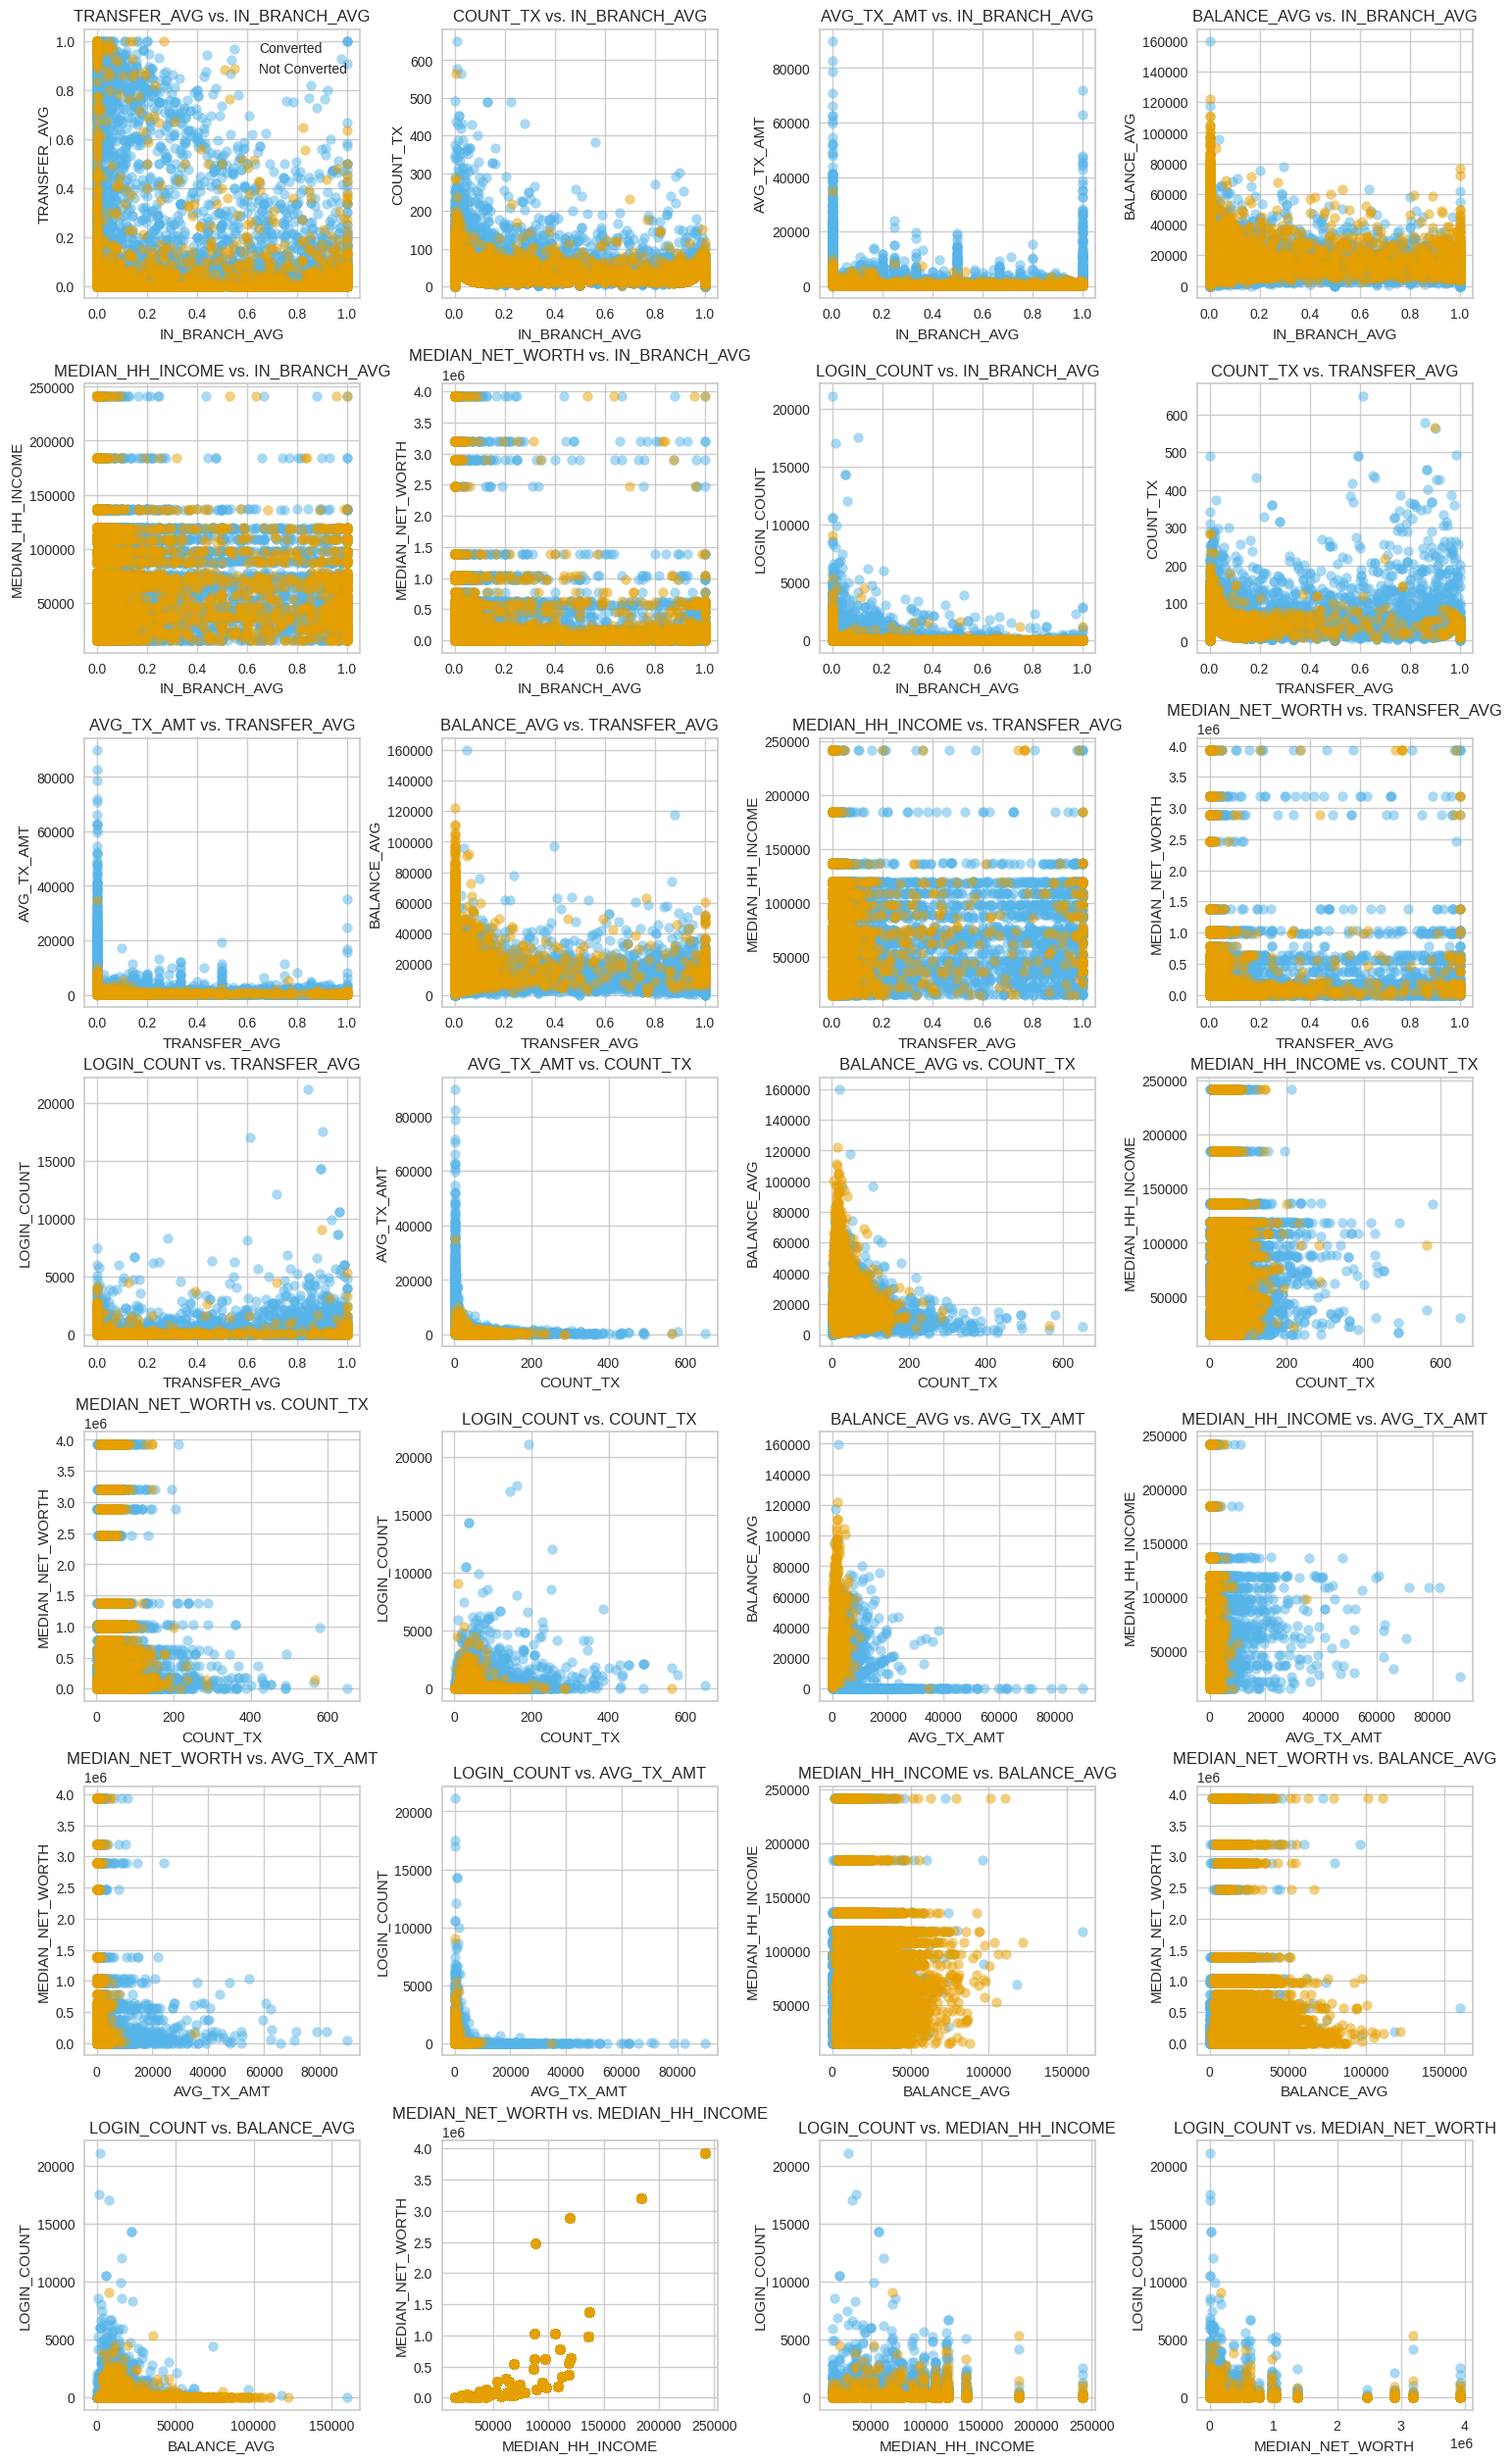

In [ ]:
fig, axes = plt.subplots(7, 4, figsize=(15, 25), constrained_layout=True)
axes = axes.flatten()
plot_index = 0

for i in range(8):
    for j in range(i+1, 8):
        x = numeric_small[i]
        y = numeric_small[j]

        converted = indirect_small[indirect_small['CONVERTED'] == 1]
        not_converted = indirect_small[indirect_small['CONVERTED'] == 0]

        axes[plot_index].scatter(converted[x], converted[y], color='#56B4E9', alpha=0.5, label='Converted' if plot_index == 0 else "")
        axes[plot_index].scatter(not_converted[x], not_converted[y], color='#E69F00', alpha=0.5, label='Not Converted' if plot_index == 0 else "")
        axes[plot_index].set_xlabel(x)
        axes[plot_index].set_ylabel(y)
        axes[plot_index].set_title(f'{y} vs. {x}')
        if plot_index == 0:
            axes[plot_index].legend()

        plot_index += 1

for idx in range(plot_index, len(axes)):
    axes[idx].axis('off')

plt.show()

#### Outliers

From the data visualizations, it is apparent that there exists [outliers](https://en.wikipedia.org/wiki/Outlier) within almost every variable. In order to create a more accurate model, I performed outlier identification based upon an [Interquartile Range (IQR)](https://en.wikipedia.org/wiki/Interquartile_range) threshold. The outliers and their count were then analyzed for performing outlier removal. In performing outlier removal, there often lies issues with insufficient data or [high dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). Dependent on the extent of these two issues, I decided to not execute outlier removal for the data set, as approximately 74% of the data was identified as an outlier. When inspecting the outliers and referring to a real-life perspective with the context of natural phenomena, the presence of "outliers" within this data set is inevitable. Within financial institutions, there lies a large spread between members and the money that is available to them, lending themselves to other pieces of information that are influenced by these significant differences. For the integrity of the data set, as well as giving the created models as much information as possible, outlier removal was not performed.

In [ ]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

In [ ]:
indirect_clean = indirect_small.copy()

for column in numeric:
    indirect_clean = remove_outliers(indirect_clean, column)

print('There were ', len(indirect_small) - len(indirect_clean) , 'outliers in the data set.')

There were  25673 outliers in the data set.


In [ ]:
print("After removing the outliers from the data set, there are", len(indirect_clean), "observations left.")

After removing the outliers from the data set, there are 8824 observations left.


Below, are data visualizations for the data set **with** outliers removed. It is apparent that outlier removal highly affects the data and the variables' distributions.

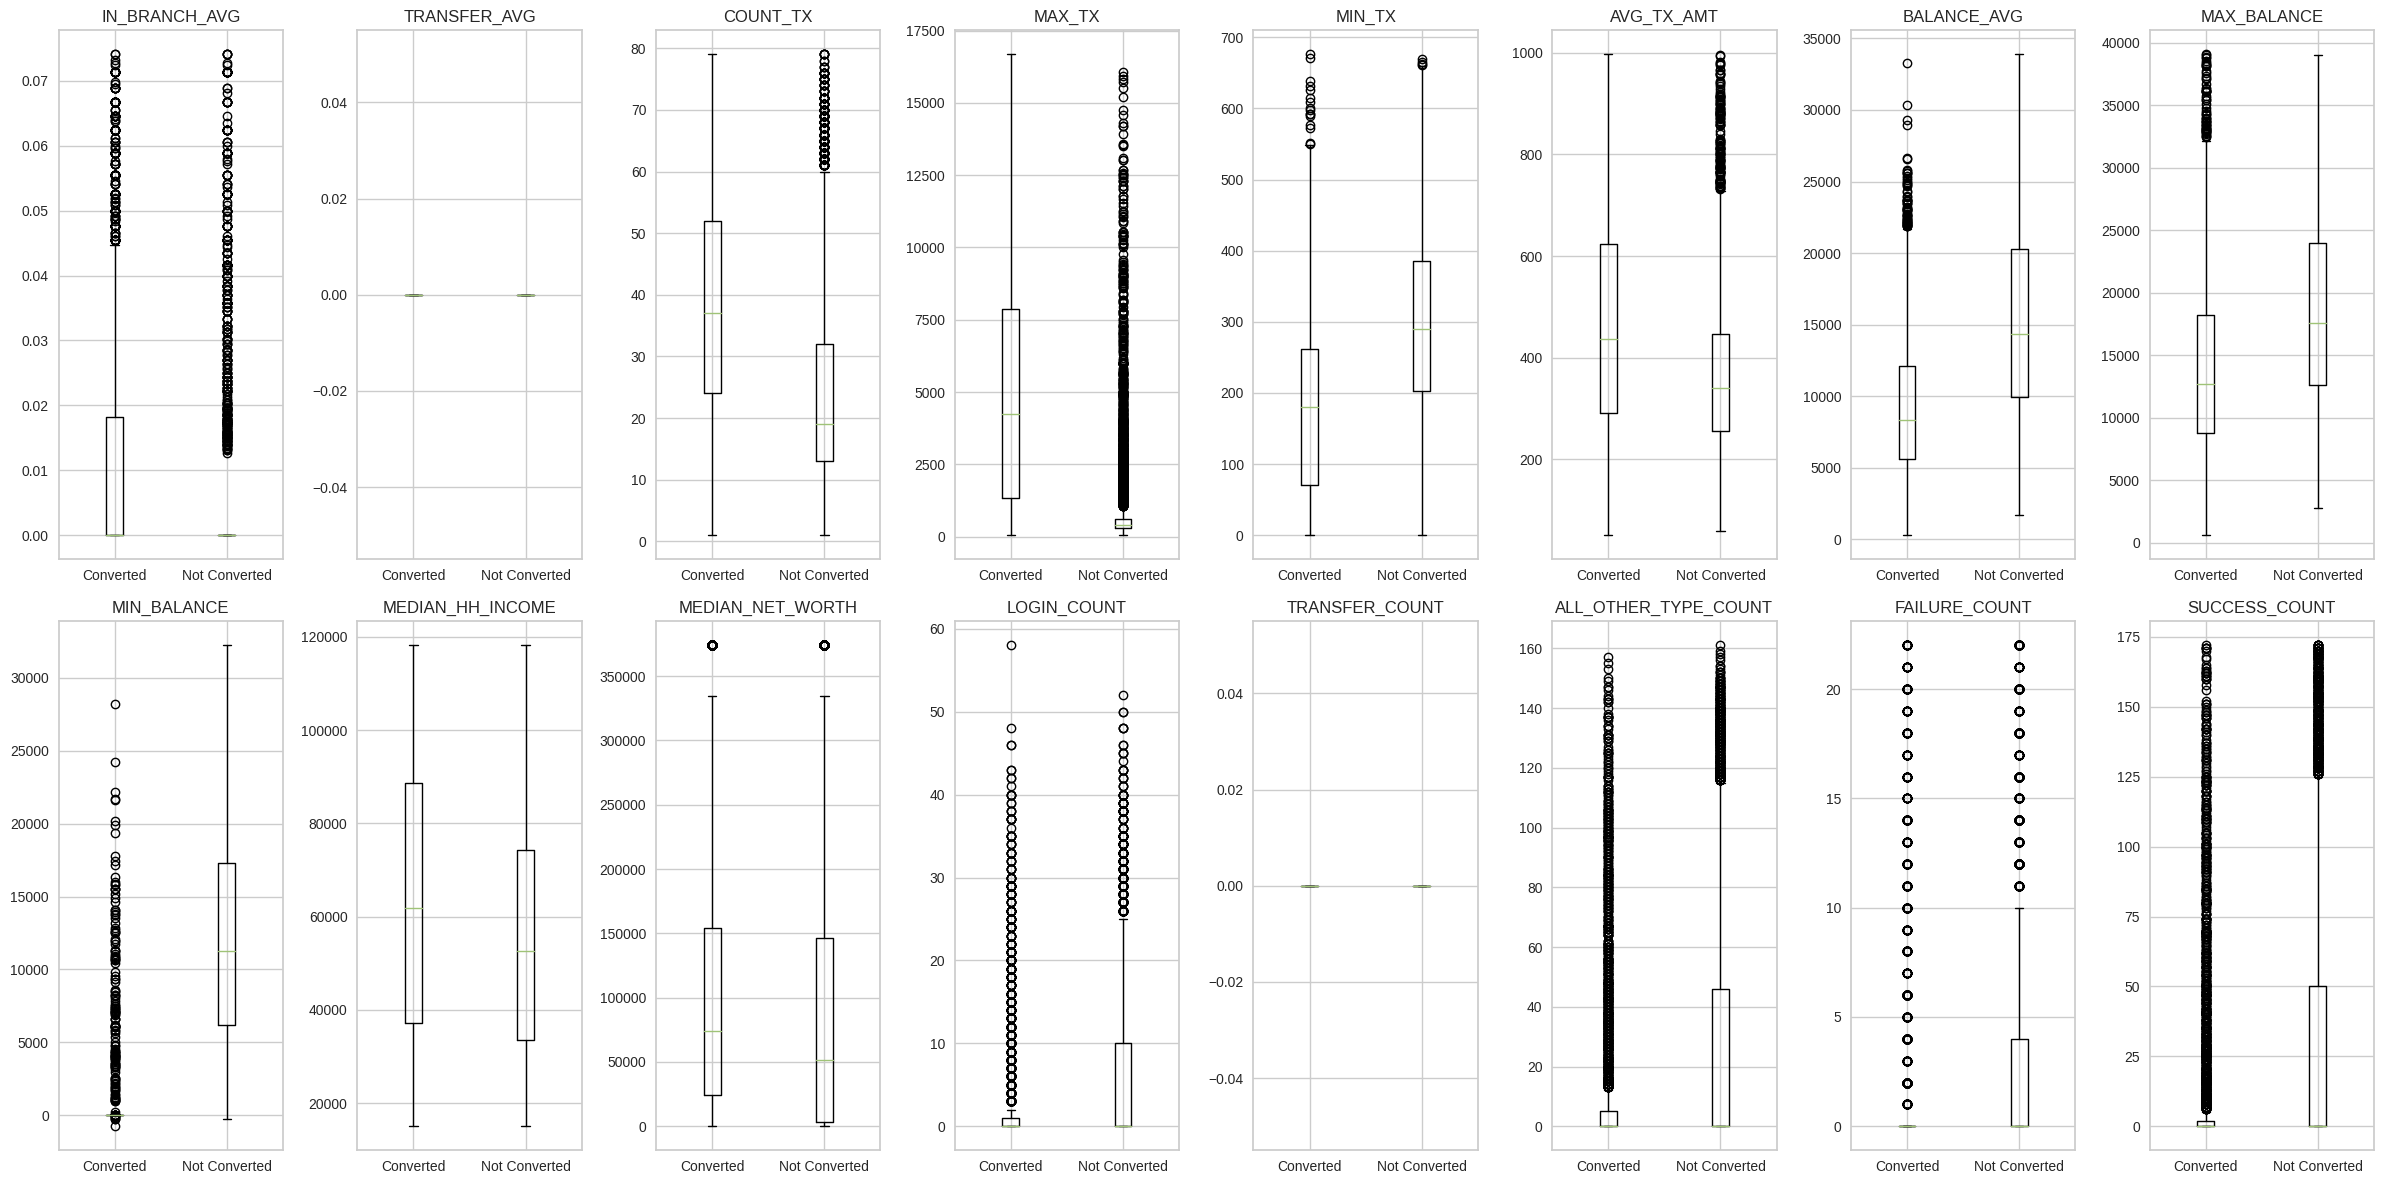

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(24, 12))

for i, variable in enumerate(numeric):
    row = i // 8
    col = i % 8

    converted = indirect_clean[indirect_clean['CONVERTED'] == 1][variable].dropna()
    not_converted = indirect_clean[indirect_clean['CONVERTED'] == 0][variable].dropna()

    ax = axes[row, col]
    ax.boxplot([converted, not_converted], labels=['Converted', 'Not Converted'])
    ax.set_title(variable)

plt.tight_layout()
plt.show()

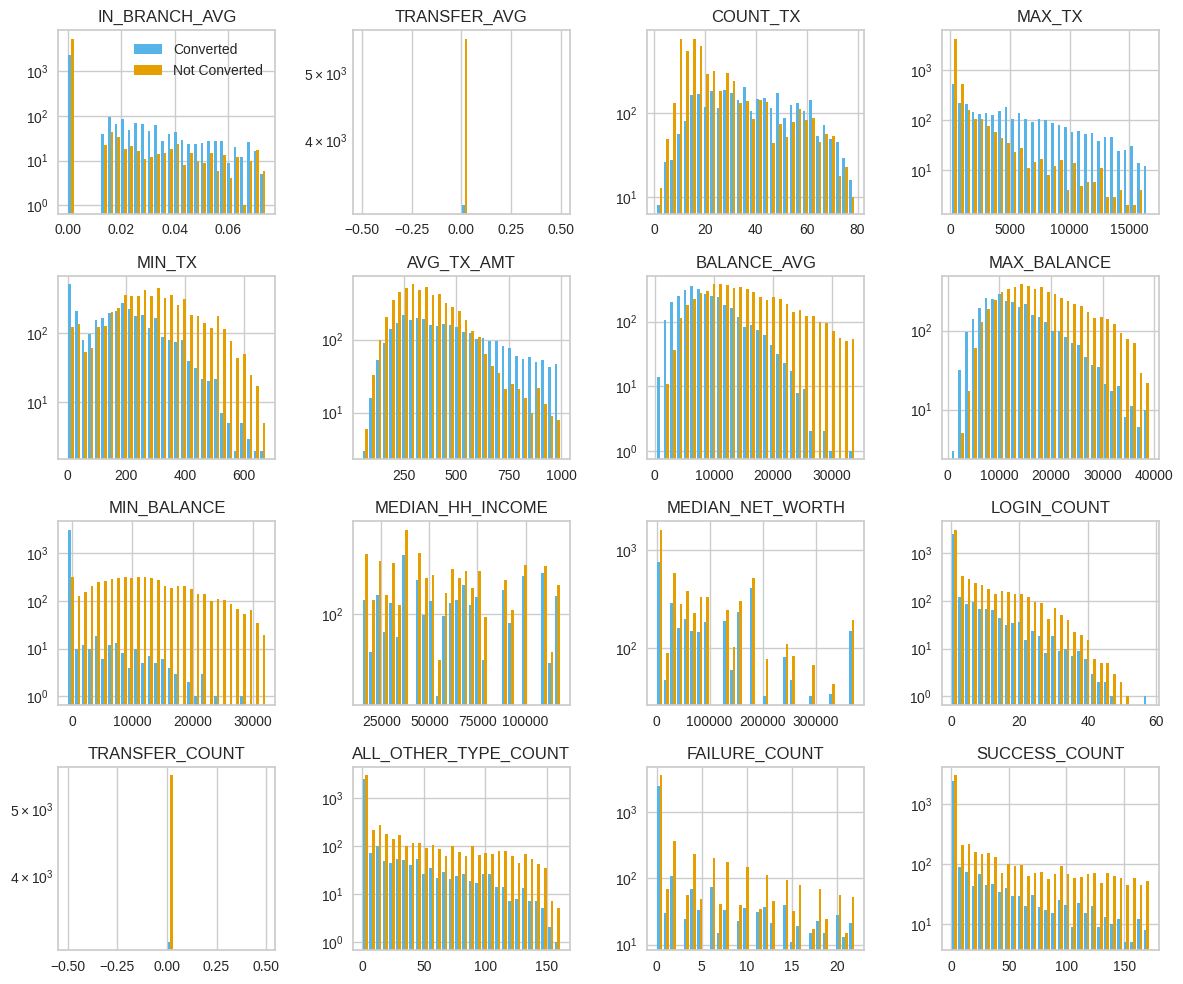

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 10))

for i, variable in enumerate(numeric):
    row = i // 4
    col = i % 4

    converted = indirect_clean[indirect_clean['CONVERTED'] == 1][variable].dropna()
    not_converted = indirect_clean[indirect_clean['CONVERTED'] == 0][variable].dropna()

    ax = axes[row, col]
    ax.hist([converted, not_converted], bins=30, label=['Converted', 'Not Converted'],
            color=['#56B4E9', '#E69F00'], log=True)
    ax.set_title(variable)
    if row == 0 and col == 0:
        ax.legend(['Converted', 'Not Converted'])

plt.tight_layout()
plt.show()

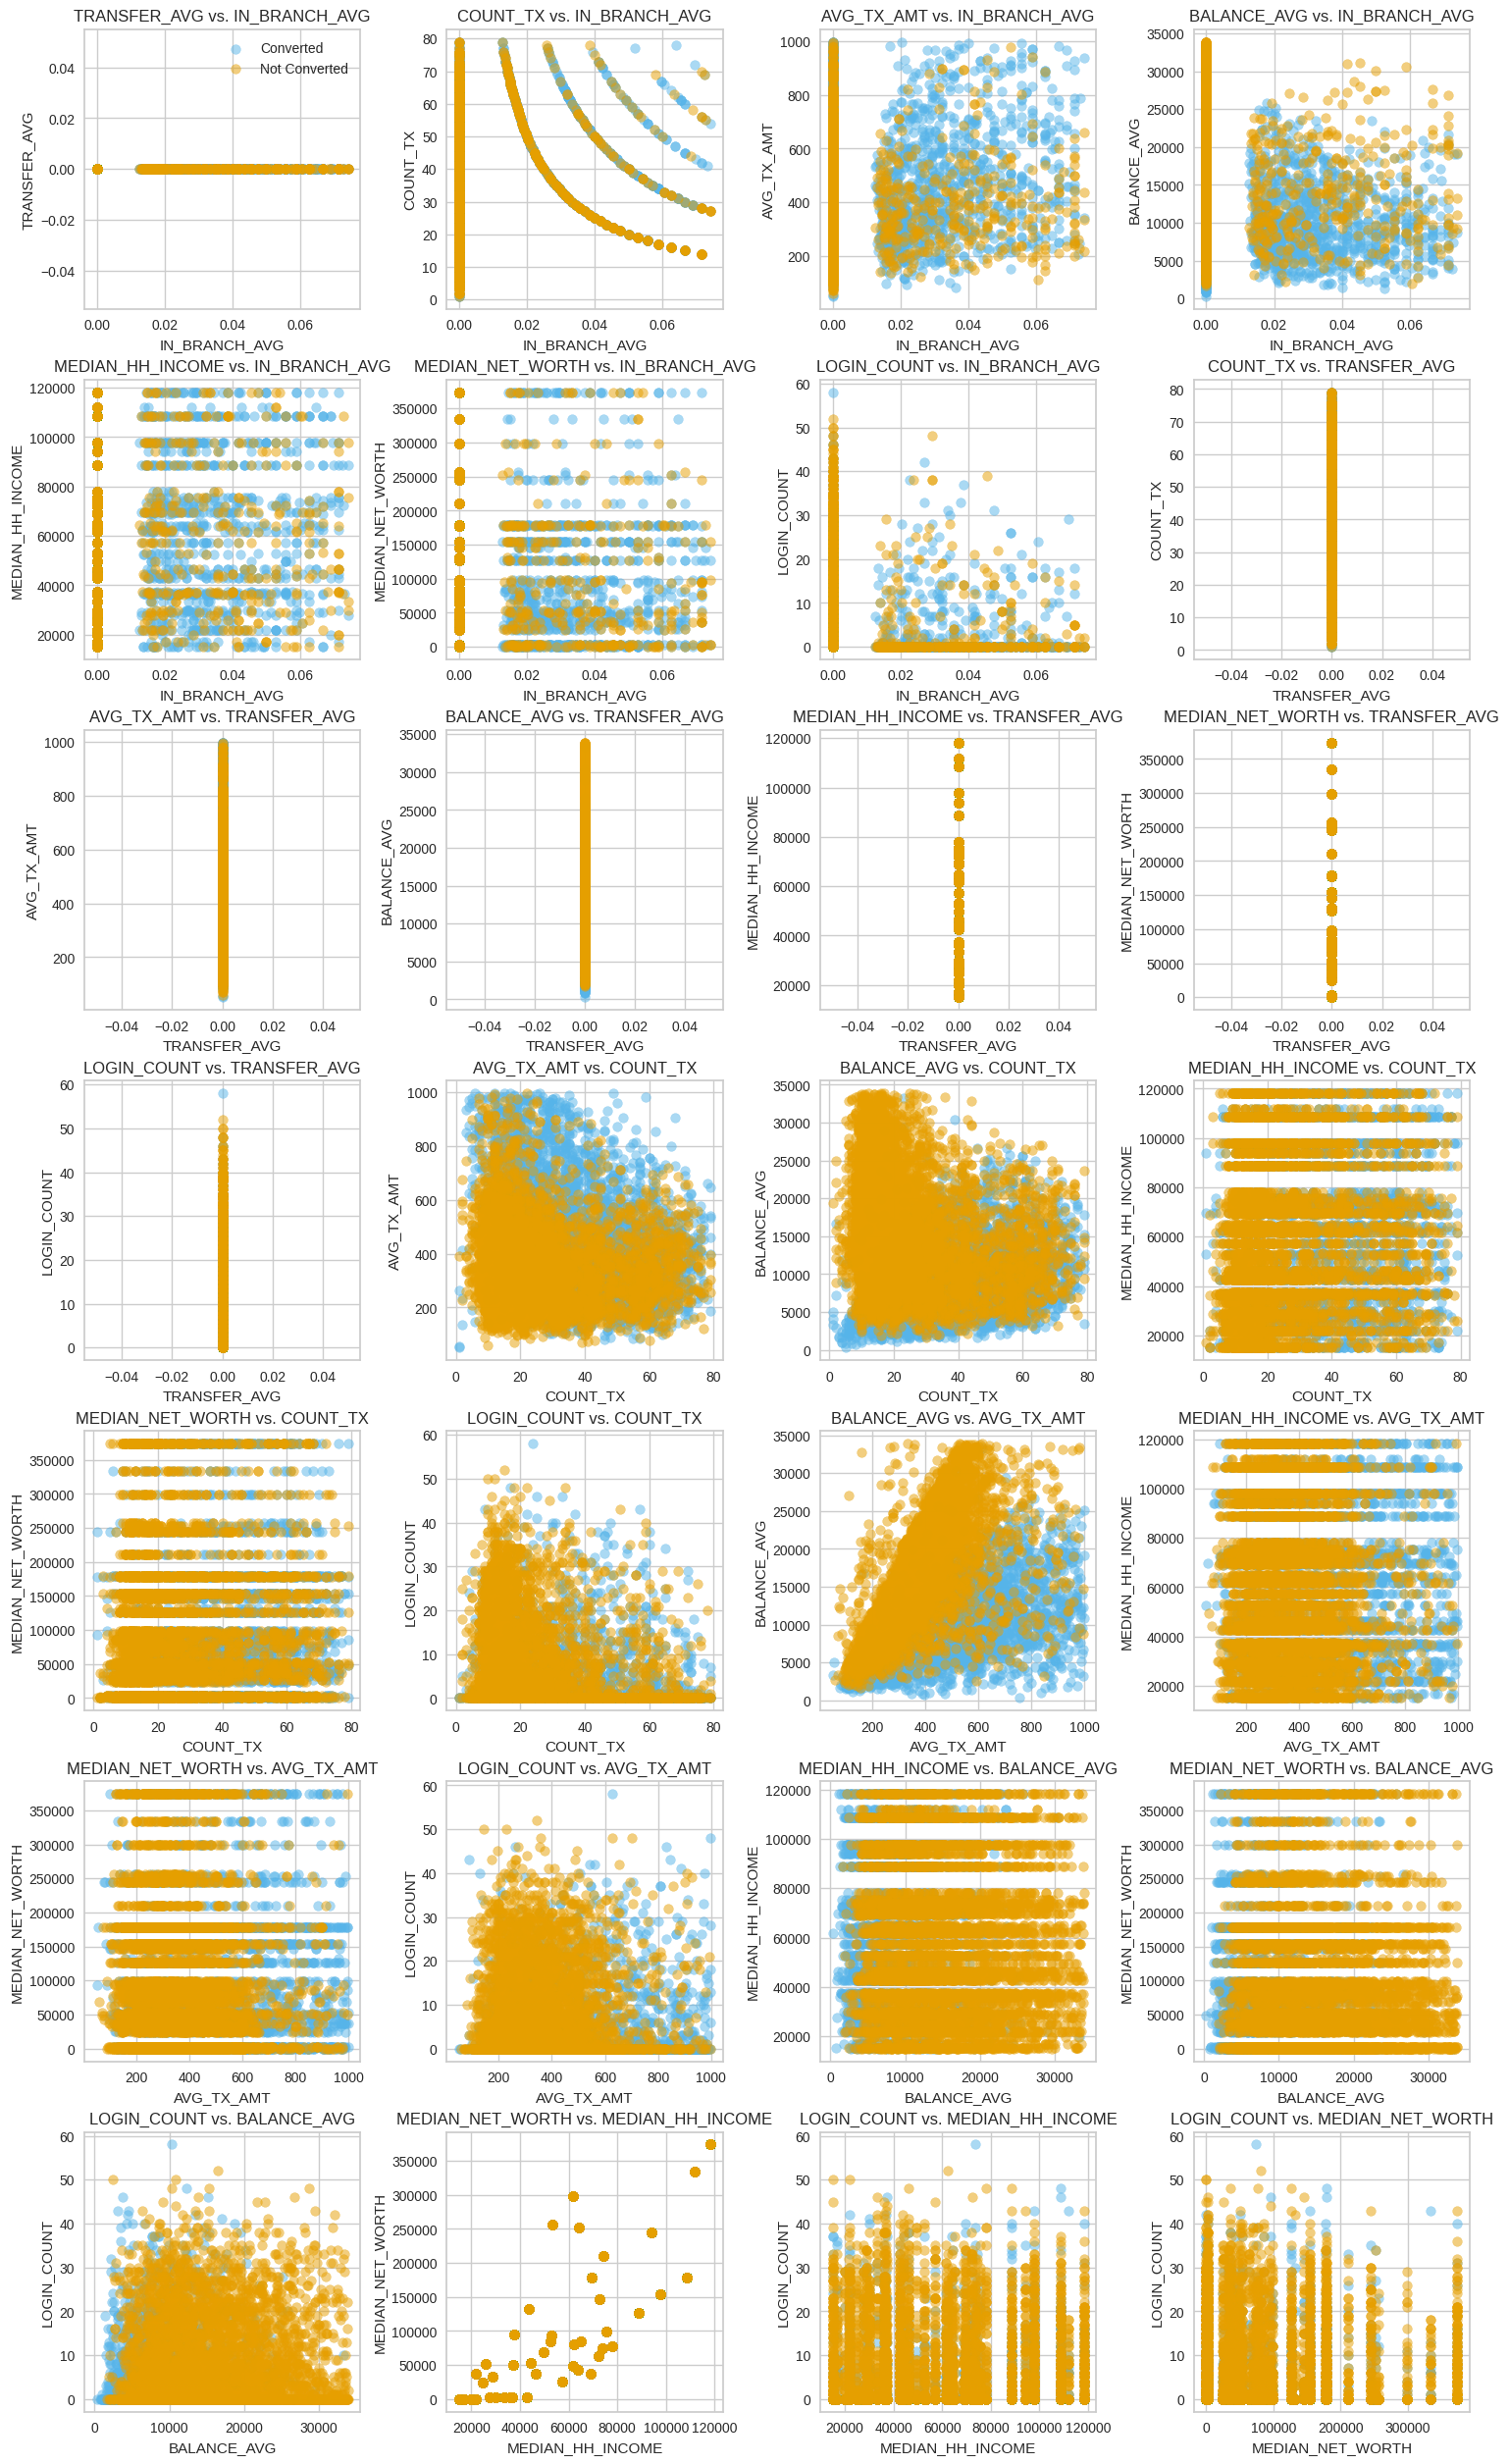

In [ ]:
fig, axes = plt.subplots(7, 4, figsize=(15, 25), constrained_layout=True)
axes = axes.flatten()
plot_index = 0

for i in range(8):
    for j in range(i+1, 8):
        x = numeric_small[i]
        y = numeric_small[j]

        converted = indirect_clean[indirect_clean['CONVERTED'] == 1]
        not_converted = indirect_clean[indirect_clean['CONVERTED'] == 0]

        axes[plot_index].scatter(converted[x], converted[y], color='#56B4E9', alpha=0.5, label='Converted' if plot_index == 0 else "")
        axes[plot_index].scatter(not_converted[x], not_converted[y], color='#E69F00', alpha=0.5, label='Not Converted' if plot_index == 0 else "")
        axes[plot_index].set_xlabel(x)
        axes[plot_index].set_ylabel(y)
        axes[plot_index].set_title(f'{y} vs. {x}')
        if plot_index == 0:
            axes[plot_index].legend()

        plot_index += 1

for idx in range(plot_index, len(axes)):
    axes[idx].axis('off')

plt.show()

### Modeling

This exploratory analysis aims to look at various pieces of member data, and their possible association with indirect member conversion to a converted indirect member. After initial data exploration, two machine learning models; logistic regression (LR) and support vector machine (SVM) were implemented to uncover potential underlying trends within the data to help in explaining member conversion, as well as act as a predictive model for unconverted indirect member monitoring, respectively. These two models both modeled and estimated the relationship between the input variables (member data) and the response variable (conversion).

In [ ]:
# Handle categorical data: Fill missing values with a placeholder and apply one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Handle quantitative data: Fill missing values with median and scale data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('cat', categorical_transformer, categorical)])

# Split data into features and target
X = indirect_small.drop('CONVERTED', axis=1)
y = indirect_small['CONVERTED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Set of random states for accuracy averages
set_of_states = [72, 101, 202, 303, 404, 1080, 2160, 4320, 7777, 42]

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
                xticklabels=['Converted', 'Not Converted'],
                yticklabels=['Converted', 'Not Converted'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

#### Logistic Regression

##### Base Model

In [ ]:
LogReg_pipeline = make_pipeline(
    preprocessor,
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=1000))

LogReg_pipeline.fit(X_train, y_train)

y_pred_base = LogReg_pipeline.predict(X_test)

In [ ]:
accuracy_base = accuracy_score(y_test, y_pred_base)
print(f"Base Model Accuracy: {accuracy_base:.4f}")

Base Model Accuracy: 0.8985


In [ ]:
# Access the LogisticRegression model from the pipeline
model_LogReg = LogReg_pipeline.named_steps['logisticregression']

# Get the feature names from the ColumnTransformer
base_features = LogReg_pipeline.named_steps['columntransformer'].get_feature_names_out()

# Create a DataFrame of the coefficients with the correct feature names
base_coefficients = pd.DataFrame(model_LogReg.coef_[0], index=base_features, columns=['Coefficient'])

# Get the intercept from the model
intercept = model_LogReg.intercept_[0]

# Append the intercept to the DataFrame
base_coefficients.loc['intercept'] = intercept

# Print the DataFrame including the intercept
print(base_coefficients)

                                        Coefficient
num__IN_BRANCH_AVG                         0.184228
num__TRANSFER_AVG                          0.948996
num__COUNT_TX                             -0.036156
num__MAX_TX                                0.134009
num__MIN_TX                               -0.909114
num__AVG_TX_AMT                            1.440074
num__BALANCE_AVG                           0.133948
num__MAX_BALANCE                          -0.170078
num__MIN_BALANCE                          -3.781479
num__MEDIAN_HH_INCOME                      0.126497
num__MEDIAN_NET_WORTH                     -0.051095
num__LOGIN_COUNT                          -0.002746
num__TRANSFER_COUNT                       -0.068573
num__ALL_OTHER_TYPE_COUNT                  0.071712
num__FAILURE_COUNT                         0.105712
num__SUCCESS_COUNT                         0.046913
cat__ACCOUNT_TYPE_Business Member          0.079358
cat__ACCOUNT_TYPE_Charge Off Account       0.745666
cat__ACCOUNT

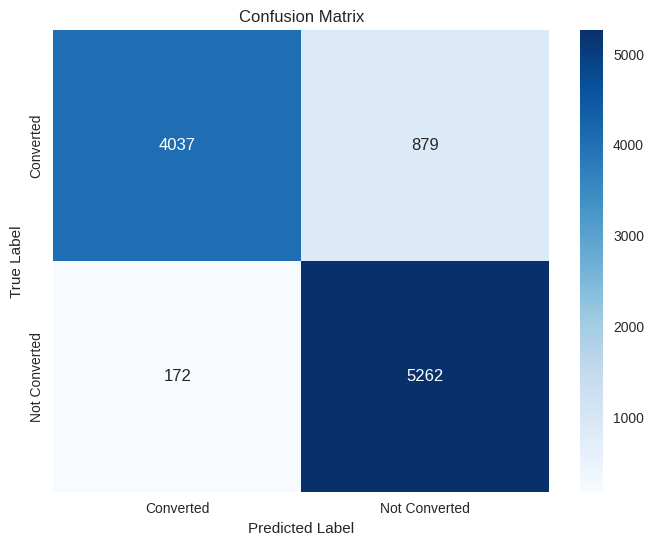

In [ ]:
base_matrix = confusion_matrix(y_test, y_pred_base)
plot_confusion_matrix(base_matrix)

In [ ]:
# Runs 10 different random states and takes accuracy average and standard deviation
accuracies_base = []

for element in set_of_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=element)

    LogReg_pipeline = make_pipeline(
        preprocessor,
        StandardScaler(with_mean=False),
        LogisticRegression(max_iter=1000))
    LogReg_pipeline.fit(X_train, y_train)
    y_pred_base_avg = LogReg_pipeline.predict(X_test)
    accuracies_base.append(accuracy_score(y_test, y_pred_base_avg))

accuracy_base_avg = np.mean(accuracies_base)
print(f"Base Model Accuracy Average: {accuracy_base_avg:.4f}")

accuracy_base_sd = statistics.stdev(accuracies_base)
print(f"Standard Deviation: {accuracy_base_sd:.4f}")

Base Model Accuracy Average: 0.8954
Standard Deviation: 0.0023


##### Elastic Net

In [ ]:
pipeline_elastic_net = make_pipeline(
    preprocessor,
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0))

pipeline_elastic_net.fit(X_train, y_train)

y_pred_net = pipeline_elastic_net.predict(X_test)

In [ ]:
accuracy_net = accuracy_score(y_test, y_pred_net)
print(f"Elastic Net Model Accuracy: {accuracy_net:.4f}")

Elastic Net Model Accuracy: 0.8985


In [ ]:
# Accessing the logistic regression model from the pipeline
logreg_model_elastic_net = pipeline_elastic_net.named_steps['logisticregression']

# Getting the feature names from the ColumnTransformer
net_features = pipeline_elastic_net.named_steps['columntransformer'].get_feature_names_out()

# Creating a DataFrame of the coefficients with the correct feature names
net_coefficients = pd.DataFrame(logreg_model_elastic_net.coef_[0], index=net_features, columns=['Coefficient'])

# Accessing the intercept from the logistic regression model
intercept = logreg_model_elastic_net.intercept_[0]

# Appending the intercept to the DataFrame
net_coefficients.loc['intercept'] = intercept

# Printing the DataFrame including the intercept
print(net_coefficients)

                                        Coefficient
num__IN_BRANCH_AVG                         0.184444
num__TRANSFER_AVG                          0.951401
num__COUNT_TX                             -0.042008
num__MAX_TX                                0.143680
num__MIN_TX                               -0.833134
num__AVG_TX_AMT                            1.365515
num__BALANCE_AVG                           0.130200
num__MAX_BALANCE                          -0.164194
num__MIN_BALANCE                          -3.794387
num__MEDIAN_HH_INCOME                      0.123300
num__MEDIAN_NET_WORTH                     -0.049612
num__LOGIN_COUNT                           0.003860
num__TRANSFER_COUNT                       -0.064782
num__ALL_OTHER_TYPE_COUNT                  0.067159
num__FAILURE_COUNT                         0.104764
num__SUCCESS_COUNT                         0.043998
cat__ACCOUNT_TYPE_Business Member          0.056428
cat__ACCOUNT_TYPE_Charge Off Account       0.790852
cat__ACCOUNT

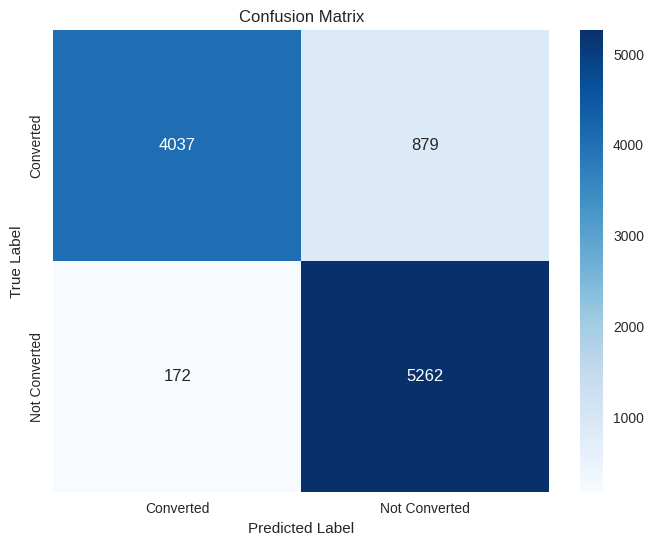

In [ ]:
net_matrix = confusion_matrix(y_test, y_pred_net)
plot_confusion_matrix(net_matrix)

In [ ]:
# Runs 10 different random states, takes accuracy average, and standard deviation
accuracies_net = []

for element in set_of_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=element)

    pipeline_elastic_net = make_pipeline(
        preprocessor,
        StandardScaler(with_mean=False),
        LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0))
    pipeline_elastic_net.fit(X_train, y_train)
    y_pred_net_avg = pipeline_elastic_net.predict(X_test)
    accuracies_net.append(accuracy_score(y_test, y_pred_net_avg))

accuracy_net_avg = np.mean(accuracies_net)
print(f"Elastic Net Model Accuracy Average: {accuracy_net_avg:.4f}")

accuracy_net_sd = statistics.stdev(accuracies_net)
print(f"Standard Deviation: {accuracy_net_sd:.4f}")

Elastic Net Model Accuracy Average: 0.8954
Standard Deviation: 0.0024


Both the base logistic regression model and the elastic net model yielded almost identical results in our evaluation. This similarity suggests that the dataset is robust against the type of regularization used, indicating minimal issues with feature collinearity or model overfitting. The equivalent performance of these models implies that the predictors are effective and the dataset may not require complex regularization strategies to achieve good accuracy. Thus, even a simple logistic regression approach appears adequate for capturing the essential patterns in the data without additional adjustments.

#### Support Vector Machine (SVM)

In [ ]:
# Create a preprocessing and training pipeline
SVM_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC(probability=True))])

# Train the SVM model
SVM_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_svm = SVM_pipeline.predict(X_test)

In [ ]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Model Accuracy: {accuracy_svm:.4f}")

SVM Model Accuracy: 0.9058


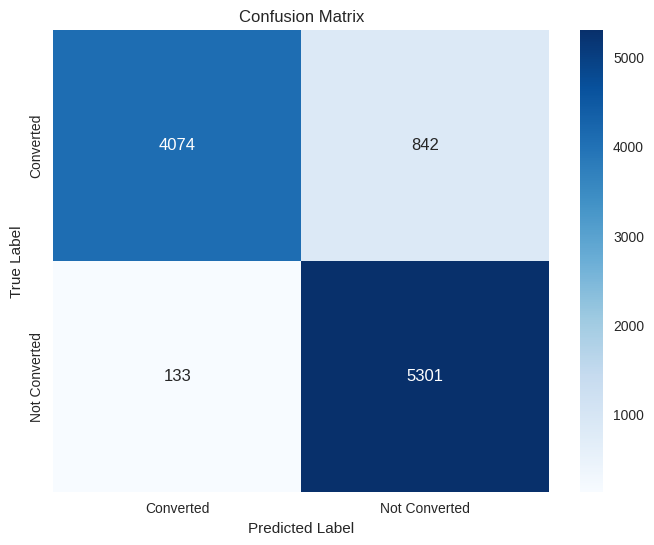

In [ ]:
svm_matrix = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(svm_matrix)

In [ ]:
# Runs 10 different random states, takes accuracy average, and standard deviation
accuracies_svm = []

for element in set_of_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=element)

    SVM_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC(probability=True))])
    SVM_pipeline.fit(X_train, y_train)
    y_pred_svm_avg = SVM_pipeline.predict(X_test)
    accuracies_svm.append(accuracy_score(y_test, y_pred_svm_avg))

accuracy_svm_avg = np.mean(accuracies_svm)
print(f"SVM Model Accuracy Average: {accuracy_svm_avg:.4f}")

accuracy_svm_sd = statistics.stdev(accuracies_svm)
print(f"Standard Deviation: {accuracy_svm_sd:.4f}")

SVM Model Accuracy Average: 0.9021
Standard Deviation: 0.0021


The SVM model did slightly better than both the base and elastic net logistic regression models. However, logistic regression might still be the better choice because of its greater interpretability. With logistic regression, you can see which features are important and how they affect the predictions. This makes it straightforward to explain why the model makes certain decisions. Since the difference in performance is small, the clear explanations provided by logistic regression could make it more useful.

#### Demographic Modeling

In [ ]:
# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_demo),
        ('cat', categorical_transformer, categorical_demo)])

# Split data into features and target
X_demo = indirect_small.drop('CONVERTED', axis=1)
y_demo = indirect_small['CONVERTED']

X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X_demo, y_demo, test_size=0.3, random_state=42)

##### Base Model (Demographic)

In [ ]:
demo_LogReg_pipeline = make_pipeline(
    preprocessor,
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=1000))

demo_LogReg_pipeline.fit(X_train_demo, y_train_demo)

y_pred_base_demo = demo_LogReg_pipeline.predict(X_test_demo)

In [ ]:
accuracy_base_demo = accuracy_score(y_test, y_pred_base_demo)
print(f"Demographic Base Model Accuracy: {accuracy_base_demo:.4f}")

Demographic Base Model Accuracy: 0.5902


In [ ]:
# Access the LogisticRegression model from the pipeline
demo_model_LogReg = demo_LogReg_pipeline.named_steps['logisticregression']

# Get the feature names from the ColumnTransformer
base_demo_features = demo_LogReg_pipeline.named_steps['columntransformer'].get_feature_names_out()

# Create a DataFrame of the coefficients with the correct feature names
base_demo_coefficients = pd.DataFrame(demo_model_LogReg.coef_[0], index=base_demo_features, columns=['Coefficient'])

# Get the intercept from the model
base_demo_intercept = demo_model_LogReg.intercept_[0]

# Append the intercept to the DataFrame
base_demo_coefficients.loc['intercept'] = base_demo_intercept

# Print the DataFrame including the intercept
print(base_demo_coefficients)

                                      Coefficient
num__MEDIAN_HH_INCOME                    0.146459
num__MEDIAN_NET_WORTH                   -0.047940
cat__AGE_CLASS_25-34                    -0.030812
cat__AGE_CLASS_35-44                     0.034731
cat__AGE_CLASS_45-54                     0.002355
cat__AGE_CLASS_55-64                     0.005996
cat__AGE_CLASS_Over 65                   0.087286
cat__AGE_CLASS_Under 25                 -0.211690
cat__AGE_CLASS_None                     -0.071416
cat__EDUCATION_CLASS_Bachelor Degree     0.008216
cat__EDUCATION_CLASS_Graduate Plus      -0.001735
cat__EDUCATION_CLASS_High School        -0.025203
cat__EDUCATION_CLASS_Some College       -0.018332
cat__EDUCATION_CLASS_None                0.023651
cat__EMPLOYMENT_CLASS_Management        -0.029238
cat__EMPLOYMENT_CLASS_Retired           -0.024491
cat__EMPLOYMENT_CLASS_Unemployed         0.020317
cat__EMPLOYMENT_CLASS_None               0.023651
cat__STATE_STATUS_CO                     0.138736


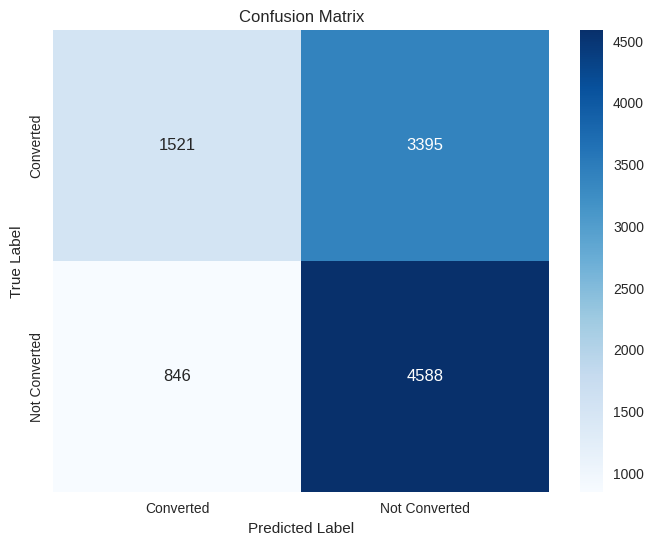

In [ ]:
base_demo_matrix = confusion_matrix(y_test_demo, y_pred_base_demo)
plot_confusion_matrix(base_demo_matrix)

In [ ]:
# Runs 10 different random states, takes accuracy average, and standard deviation
accuracies_base_demo = []

for element in set_of_states:
    X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X_demo, y_demo, test_size=0.3, random_state=element)

    demo_LogReg_pipeline = make_pipeline(
        preprocessor,
        StandardScaler(with_mean=False),
        LogisticRegression(max_iter=1000))
    demo_LogReg_pipeline.fit(X_train_demo, y_train_demo)
    y_pred_base_avg_demo = demo_LogReg_pipeline.predict(X_test_demo)
    accuracies_base_demo.append(accuracy_score(y_test_demo, y_pred_base_avg_demo))

accuracy_base_demo_avg = np.mean(accuracies_base_demo)
print(f"Demographic Base Model Accuracy Average: {accuracy_base_demo_avg:.4f}")

accuracy_base_demo_sd = statistics.stdev(accuracies_base_demo)
print(f"Standard Deviation: {accuracy_base_demo_sd:.4f}")

Demographic Base Model Accuracy Average: 0.5942
Standard Deviation: 0.0042


##### Elastic Net (Demographic)

In [ ]:
demo_pipeline_elastic_net = make_pipeline(
    preprocessor,
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0))

demo_pipeline_elastic_net.fit(X_train_demo, y_train_demo)

y_pred_net_demo = demo_pipeline_elastic_net.predict(X_test_demo)

In [ ]:
accuracy_net_demo = accuracy_score(y_test_demo, y_pred_net_demo)
print(f"Demographic Elastic Net Model Accuracy: {accuracy_net_demo:.4f}")

Demographic Elastic Net Model Accuracy: 0.5902


In [ ]:
# Accessing the logistic regression model from the pipeline
demo_logreg_model_elastic_net = demo_pipeline_elastic_net.named_steps['logisticregression']

# Getting the feature names from the ColumnTransformer
demo_net_features = demo_pipeline_elastic_net.named_steps['columntransformer'].get_feature_names_out()

# Creating a DataFrame of the coefficients with the correct feature names
demo_net_coefficients = pd.DataFrame(demo_logreg_model_elastic_net.coef_[0], index=demo_net_features, columns=['Coefficient'])

# Accessing the intercept from the logistic regression model
demo_net_intercept = demo_logreg_model_elastic_net.intercept_[0]

# Appending the intercept to the DataFrame
demo_net_coefficients.loc['intercept'] = demo_net_intercept

# Printing the DataFrame including the intercept
print(demo_net_coefficients)

                                      Coefficient
num__MEDIAN_HH_INCOME                    0.145824
num__MEDIAN_NET_WORTH                   -0.047443
cat__AGE_CLASS_25-34                    -0.037865
cat__AGE_CLASS_35-44                     0.027689
cat__AGE_CLASS_45-54                    -0.004086
cat__AGE_CLASS_55-64                     0.000000
cat__AGE_CLASS_Over 65                   0.082000
cat__AGE_CLASS_Under 25                 -0.215002
cat__AGE_CLASS_None                     -0.071852
cat__EDUCATION_CLASS_Bachelor Degree     0.009299
cat__EDUCATION_CLASS_Graduate Plus       0.000001
cat__EDUCATION_CLASS_High School        -0.023296
cat__EDUCATION_CLASS_Some College       -0.016798
cat__EDUCATION_CLASS_None                0.025523
cat__EMPLOYMENT_CLASS_Management        -0.000864
cat__EMPLOYMENT_CLASS_Retired            0.000000
cat__EMPLOYMENT_CLASS_Unemployed         0.040721
cat__EMPLOYMENT_CLASS_None               0.025523
cat__STATE_STATUS_CO                     0.125890


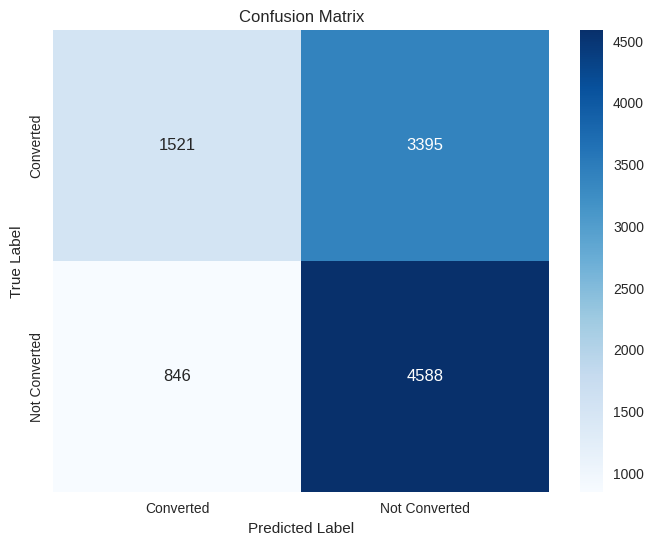

In [ ]:
demo_net_matrix = confusion_matrix(y_test_demo, y_pred_net_demo)
plot_confusion_matrix(demo_net_matrix)

In [ ]:
# Runs 10 different random states, takes accuracy average, and standard deviation
accuracies_net_demo = []

for element in set_of_states:
    X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X_demo, y_demo, test_size=0.3, random_state=element)

    demo_pipeline_elastic_net = make_pipeline(
        preprocessor,
        StandardScaler(with_mean=False),
        LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0))
    demo_pipeline_elastic_net.fit(X_train_demo, y_train_demo)
    y_pred_net_avg_demo = demo_pipeline_elastic_net.predict(X_test_demo)
    accuracies_net_demo.append(accuracy_score(y_test_demo, y_pred_net_avg_demo))

accuracy_net_avg_demo = np.mean(accuracies_net_demo)
print(f"Demographic Elastic Net Model Accuracy Average: {accuracy_net_avg_demo:.4f}")

accuracy_net_demo_sd = statistics.stdev(accuracies_net_demo)
print(f"Standard Deviation: {accuracy_net_demo_sd:.4f}")

Demographic Elastic Net Model Accuracy Average: 0.5942
Standard Deviation: 0.0042


##### SVM (Demographic)

In [ ]:
# Create a preprocessing and training pipeline
demo_SVM_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC(probability=True))])

# Train the SVM model
demo_SVM_pipeline.fit(X_train_demo, y_train_demo)

# Evaluate the model
y_pred_svm_demo = demo_SVM_pipeline.predict(X_test_demo)

In [ ]:
accuracy_svm_demo = accuracy_score(y_test_demo, y_pred_svm_demo)
print(f"Demographic SVM Model Accuracy: {accuracy_svm_demo:.4f}")

Demographic SVM Model Accuracy: 0.5906


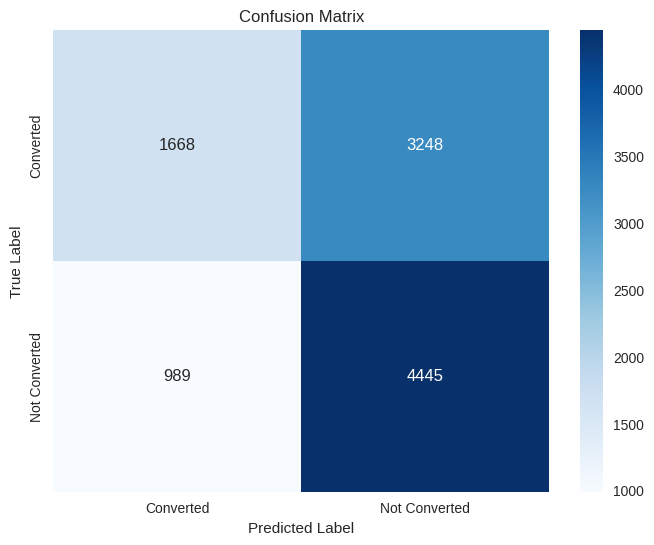

In [ ]:
demo_svm_matrix = confusion_matrix(y_test_demo, y_pred_svm_demo)
plot_confusion_matrix(demo_svm_matrix)

In [ ]:
# Runs 10 different random states, takes accuracy average, and standard deviation
accuracies_svm_demo = []

for element in set_of_states:
    X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X_demo, y_demo, test_size=0.3, random_state=element)

    demo_SVM_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC(probability=True))])
    demo_SVM_pipeline.fit(X_train_demo, y_train_demo)
    y_pred_svm_avg_demo = demo_SVM_pipeline.predict(X_test_demo)
    accuracies_svm_demo.append(accuracy_score(y_test_demo, y_pred_svm_avg_demo))

accuracy_svm_avg_demo = np.mean(accuracies_svm_demo)
print(f"Demographic SVM Model Accuracy Average: {accuracy_svm_avg_demo:.4f}")

accuracy_svm_demo_sd = statistics.stdev(accuracies_svm_demo)
print(f"Standard Deviation: {accuracy_svm_demo_sd:.4f}")

Demographic SVM Model Accuracy Average: 0.5937
Standard Deviation: 0.0034


The performance differences between the three demographic models closely mirror those observed in the full data models. In both scenarios, the base logistic regression and elastic net models deliver nearly identical results, while the SVM model exhibits slightly better performance. This pattern highlights consistent model behavior regardless of the data set's scope, emphasizing the SVM's marginal superiority in both contexts.

Although the demographic models achieve an accuracy only about 8-10% higher than a random selection model, which would expect a baseline accuracy of 50% for a binary outcome, they remain a valuable tool. These models are particularly useful for predicting the conversion likelihood of customers when no financial data is available. They provide a significant improvement over random guessing, offering targeted insights that can help optimize outreach strategies and enhance customer engagement initiatives.

### Model Comparisons

In [ ]:
def plot_confusion_matrices(conf_matrix, title, ax):
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', ax=ax, cbar=False,
                xticklabels=['Converted', 'Not Converted'],
                yticklabels=['Converted', 'Not Converted'])
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

In [ ]:
full_names = ['Base (Full Data)', 'Net (Full Data)', 'SVM (Full Data)']

accuracies_full = [accuracies_base, accuracies_net, accuracies_svm]

demo_names = ['Base (Demographic)', 'Net (Demographic)', 'SVM (Demographic)']

accuracies_demo = [accuracies_base_demo, accuracies_net_demo,
                          accuracies_svm_demo]

The accuracy scores reveal that models trained on the full dataset — every variable included — perform better, with the SVM model achieving the highest accuracy, closely followed by both the Base and Elastic Net models. In contrast, models using only demographic variables show significantly lower performance. However, these demographic-based models still hold considerable value. They can be effectively used to predict conversion likelihood in customers for whom no banking data is available, allowing the Credit Union to engage with potential members even in the absence of comprehensive financial profiles. This broadens the scope of outreach and inclusivity, ensuring that opportunities for membership growth are maximized.

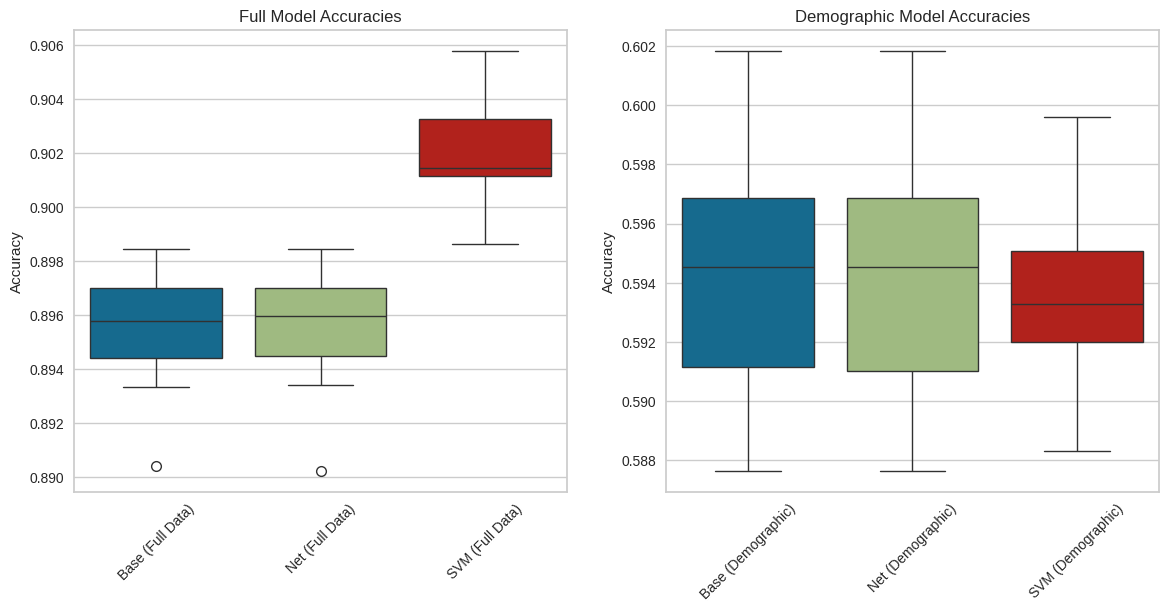

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Full model Plot
sns.boxplot(data=accuracies_full, ax=ax1)
ax1.set_xticks(range(3))
ax1.set_xticklabels(full_names, rotation=45)
ax1.set_title('Full Model Accuracies')
ax1.set_ylabel('Accuracy')

# Demographic model plot
sns.boxplot(data=accuracies_demo, ax=ax2)
ax2.set_xticks(range(3))
ax2.set_xticklabels(demo_names, rotation=45)
ax2.set_title('Demographic Model Accuracies')
ax2.set_ylabel('Accuracy')
plt.show()

The confusion matrices reveal that models trained with full data outperform those using only demographic data. The full data models show higher true positives and true negatives, indicating better accuracy in predicting both converted and not converted members. In contrast, demographic-only models exhibit higher false negatives and false positives, demonstrating less reliability. Yet the demographic models are still valuable when detailed banking data is unavailable.

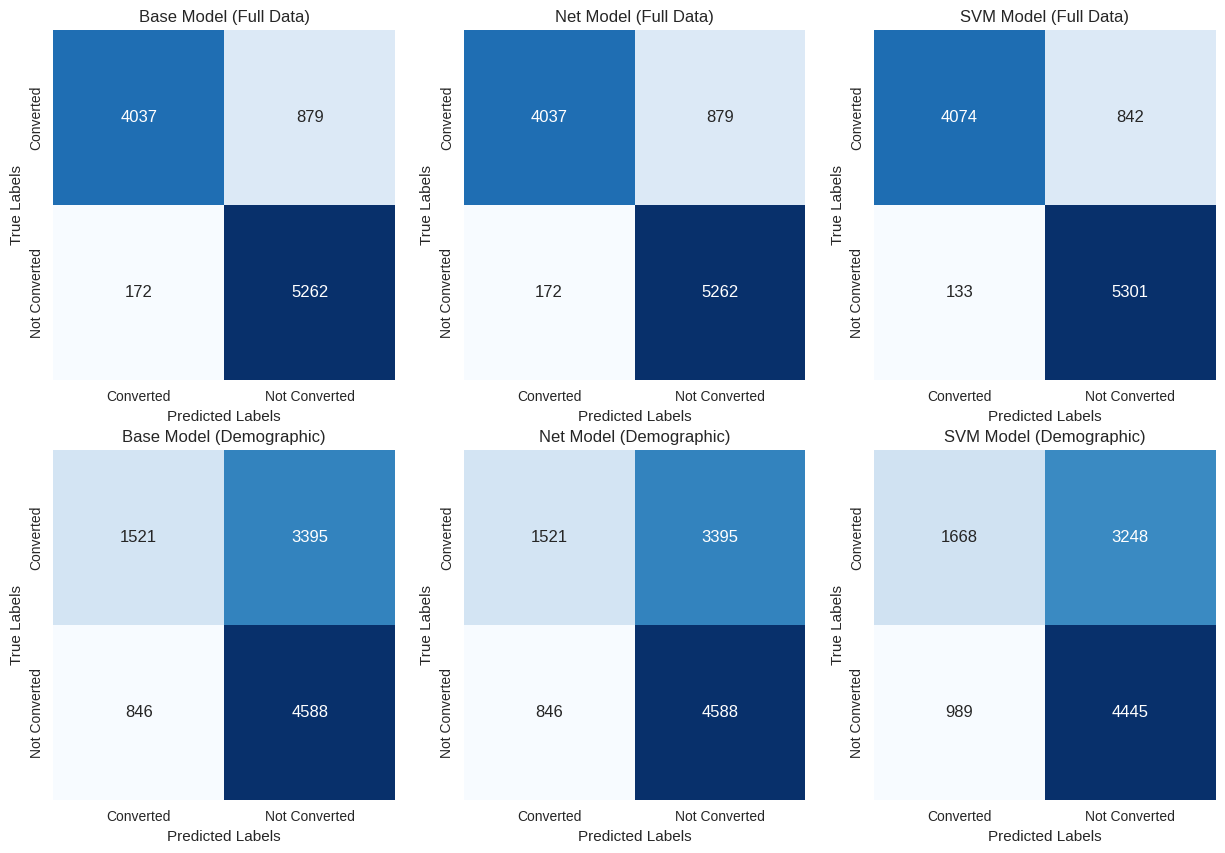

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
plot_confusion_matrices(base_matrix, 'Base Model (Full Data)', axes[0, 0])
plot_confusion_matrices(net_matrix, 'Net Model (Full Data)', axes[0, 1])
plot_confusion_matrices(svm_matrix, 'SVM Model (Full Data)', axes[0, 2])
plot_confusion_matrices(base_demo_matrix, 'Base Model (Demographic)', axes[1, 0])
plot_confusion_matrices(demo_net_matrix, 'Net Model (Demographic)', axes[1, 1])
plot_confusion_matrices(demo_svm_matrix, 'SVM Model (Demographic)', axes[1, 2])
plt.show()

### Demographic Feature Elimination

Since most of the demographic data must be purchased by the Credit Union from third parties, it is beneficial to be able to make accurate predictions with the fewest number of features and thus save resources while maintaining predictive capabilities.

The following code looks at the accuracies of all possible combinations of demographic features in the base model.

In [ ]:
all_demo_features = numeric_demo + categorical_demo

# Generate all combinations of features
feature_combos = []
for r in range(1, 7):
    feature_combos.extend(itertools.combinations(all_demo_features, r))

In [ ]:
combination_accuracies = {}

# Create model for each combination of features and test accuracy
for features in feature_combos:
    numeric_features = [f for f in features if f in numeric_demo]
    categorical_features = [f for f in features if f in categorical_demo]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)],
        remainder='drop')

    demo_LogReg_pipeline = make_pipeline(
        preprocessor,
        StandardScaler(with_mean=False),
        LogisticRegression(max_iter=1000))

    demo_LogReg_pipeline.fit(X_train_demo, y_train_demo)
    y_pred_demo = demo_LogReg_pipeline.predict(X_test_demo)

    accuracy_demo = accuracy_score(y_test_demo, y_pred_demo)
    combination_accuracies[features] = accuracy_demo

print("Accuracy for each combination of features (highest to lowest):")
sorted_combinations = sorted(combination_accuracies.items(), key=lambda item: item[1], reverse=True)
for combo, accuracy in sorted_combinations:
    print(f"\nFeatures: {combo}, \nAccuracy: {accuracy:.4f}")

Accuracy for each combination of features (highest to lowest):

Features: ('MEDIAN_HH_INCOME', 'MEDIAN_NET_WORTH', 'AGE_CLASS', 'EMPLOYMENT_CLASS', 'STATE_STATUS'), 
Accuracy: 0.5902

Features: ('MEDIAN_HH_INCOME', 'MEDIAN_NET_WORTH', 'AGE_CLASS', 'EDUCATION_CLASS', 'EMPLOYMENT_CLASS', 'STATE_STATUS'), 
Accuracy: 0.5902

Features: ('MEDIAN_HH_INCOME', 'AGE_CLASS', 'EDUCATION_CLASS', 'EMPLOYMENT_CLASS', 'STATE_STATUS'), 
Accuracy: 0.5901

Features: ('MEDIAN_HH_INCOME', 'AGE_CLASS', 'EMPLOYMENT_CLASS', 'STATE_STATUS'), 
Accuracy: 0.5900

Features: ('MEDIAN_HH_INCOME', 'AGE_CLASS', 'EDUCATION_CLASS', 'STATE_STATUS'), 
Accuracy: 0.5898

Features: ('MEDIAN_NET_WORTH', 'AGE_CLASS', 'EMPLOYMENT_CLASS', 'STATE_STATUS'), 
Accuracy: 0.5898

Features: ('MEDIAN_HH_INCOME', 'MEDIAN_NET_WORTH', 'AGE_CLASS', 'EDUCATION_CLASS', 'STATE_STATUS'), 
Accuracy: 0.5898

Features: ('AGE_CLASS', 'EDUCATION_CLASS', 'STATE_STATUS'), 
Accuracy: 0.5897

Features: ('AGE_CLASS', 'EMPLOYMENT_CLASS', 'STATE_STATUS'), 

This analysis shows that the model that only looks at AGE_CLASS and STATE_STATUS has a relatively high accuracy while only requiring two features.

This result is ideal because the age and location data for anyone applying for a loan is easily obtainable by the Credit Union and so they will be able to make predictions about whether a new loan customer is likely to become a full member without purchasing additional information.

## Conclusion

As this research project stemmed from an exploratory standpoint— where most of this analysis had not been done nor seen before— some methods or conclusions may appear to be rudimentary at first. A large takeaway that I want to give to my audience is the immense significance that these types of research projects— including methods and findings— have on various topics of study. All innovations and findings must start at an investigative level, discovering the patterns behind phenomena and bringing those to light, for both their implications and future work. Sometimes starting from scratch may seem too straightforward, but it means that you can only build upon what you find, creating a foundation for further research and findings.

The goal for this research was in regards to helping the Credit Union better understand and predict indirect member conversion, and possible data— or variable— selection that impacts that through the use of various machine learning algorithms; base logistic regression, elastic net logistic regression, and SVM. Parsing through the models created by the type of algorithm used, all three algorithms provided relatively similar accuracies in conversion prediction. The true difference lies in how these algorithms are created, as well as their explainability and interpretability. Base logistic regression, at its core, retains the most interpretability without a significant loss in predictability for indirect member conversion. In determining conversion, a base logistic regression model would be a preferred choice of the Credit Union due to its simplicity and ease of sharing throughout disciplines. During variable selection, it was found that differentiating between a solely demographic model— a model built with only demographic explanatory variables— and a full model showed a relatively large gap in accuracy of prediction. This distinction lends itself to respective problem solving. I recommend that for existing members, utilizing a full model would be most accurate in identifying conversion as the large number of observations lies within the Credit Union's full data set. In promoting conversion, the Credit Union could potentially implement targeted advertising or promotions to their loan customers to influence conversion to full membership. The demographic models, while having a smaller accuracy, provide an effective prediction algorithm for new non-converted indirect members for whom no banking data is available. Demographic data can be highly costly to collect, so I recommend that the Credit Union could save resources by utilizing a smaller demographic model and still retain relatively high accuracy. The demographic model that showed both high accuracy and cost effectiveness uses only two variables, AGE_CLASS and STATE_STATUS, and so this model is suggested for Credit Union usage.

### Future Work

In future work, I suggest an analysis into the efficacy of spending resources on targeted advertising and promotions to encourage indirect member conversion, delving into the cost and return of this Credit Union. In building upon the research done in this project, future work could  consist of redefining the threshold for outliers and outlier detection, changing the data, and re-training the machine learning algorithms with the new data set, to examine the difference between natural phenomena and true outliers. In contributing to the understanding of the models and exploring their significance, as well as accuracy, future work could revolve around the significance of the regression coefficients and their p-values to make possible distinctions between significant variables and those that do not contribute to the model.

## References

Berwick, R., An Idiot’s Guide to Support Vector Machines (SVMs), 2003, https://web.mit.edu/6.034/wwwbob/svm.pdf

Kuswanto, H., Asfihani, A., Sarumaha, Y., Ohwada, H. “Logistic Regression Ensemble for Predicting Customer Defection with Very Large Sample Size.” Procedia Computer Science, vol. 72, 2015, pp. 86-93.

Marco Tulio Ribeiro, Sameer Singh, and Carlos Guestrin. 2016. "Why Should I Trust You?": Explaining the Predictions of Any Classifier. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '16). Association for Computing Machinery, New York, NY, USA, 1135–1144. https://doi.org/10.1145/2939672.2939778

Paul, Ranjit K. “Multicollinearity: Causes, Effects, Remedies.” Roll No. 4405.

Prakash, Sasi Bhanu, Sunitha Devi Bigul; Random forest and logistic regression algorithms: A comparison of their performance. AIP Conf. Proc. 17 July 2023; 2548 (1): 050013.

Rudin, C., & Radin, J. (2019). Why Are We Using Black Box Models in AI When We Don’t Need To? A Lesson From an Explainable AI Competition. Harvard Data Science Review, 1(2). https://doi.org/10.1162/99608f92.5a8a3a3d

Sperandei, Sandro. “Understanding logistic regression analysis” Biochemia Medica, vol. 21, no. 1, 2014. http://dx.doi.org/10.11613/BM.2014.003.

Szumilas, Magdalena. “Explaining Odds Ratios.” Journal of the Canadian Academy of Child and Adolescent Psychiatry, vol. 19, no. 3, 2010, pp. 227-229.

"What are support vector machines (SVMs)?" IBM, 27 December 2023, https://www.ibm.com/topics/support-vector-machine

“What Is Logistic Regression?” IBM, IBM, Feb. 2024, www.ibm.com/topics/logistic-regression#:~:text=Resources-,...ic%20regression%3F,given%20dataset%20of%20independent%20variables.

“What Is Regularization?” IBM, 5 Mar. 2024, www.ibm.com/topics/regularization.

Zhi Zhou, April. “Improving E-Commerce Conversion Rates with Machine Learning.” April Zhi Zhou, Northwestern University, 3 March 2024, https://sites.northwestern.edu/aprilzhizhou/improving-e-commerce-conversion-rates-with-machine-learning/.

